# DSO 522: Applied Time Series Analysis for Forecasting

## Week 2: Time Series Decomposition

### Fall 2024

#### Instructor: Ron Li (substitute teaching for Dr. Matteo Sesia)
<p align="center">
  <img src="img/marshall.png" alt="Marshall School of Business" width="600"/>
</p>

## Housekeeping

### Note on Reproducibility

In order to get full credit for any assignments, homework or projects in this course, your code should run smoothly without error by the grader or the instructor.

The following excuse will not be accepted. 

<p align="center">
  <img src="img/lecture02/works-on-my-machine.jpg" alt="It works on my machine" width="300"/>
</p>

To ensure that your work is reproducible, therefor you get the credit you deserve, follow the following best practices.

### Use `Project`

1. Use the `project` feature in Rstudio. It automatically sets your working directory to the project folder and you will never need to worry "where is my xxx". See the reference [here](https://bookdown.org/ndphillips/YaRrr/projects-in-rstudio.html) and [here](https://www.reddit.com/r/Rlanguage/comments/131rlh2/what_is_the_advantage_of_using_rstudio_projects/).

<p align="center">
  <img src="img/lecture02/projects-new.png" alt="start an r project" width="300"/>
</p>

> If you know version control like Git, R project will make it easy for you as well. Use GitHub if you can. It will also creates some nice green grids to tell the world that you love coding.

### Clean Memory

2. Make sure your code run flawlessly after a **session restart**. Sometimes you make ad-hoc changes to your data or data structure and it runs just fine for that time. Before you submit your work, reset the R session to clear the memory and run your code again.

### Don't Forget Your Data

3. Submit your data as well. If you use external data or any local data, submit in the homework as well. If your dataset is large, host it on GitHub for free and use `read.csv(url_to_data)` to load it. Make sure the data is fine to be public, of course.


### Other Traps
4. Don't update libraries blindly. Check breaking changes of libraries before update them. Since we are only using famous and mature libraries in this course, this won't be a big problem.

5. Beaware of namespace and overwritten methods. Some common function names are used by different packages. Sometimes your `a` function from `A1` package is not the same `a` function from `A2` package. Use namespace to specify which `a` it is: `A1::a()` or `A2::a()` whenever needed.

Now back to business.

The Big Idea

> We can think of a time series as comprising three components: a trend-cycle component, a seasonal component, and a remainder component (containing anything else in the time series)

In this chapter, we consider the most common methods for extracting these components from a time series. Often this is done to help improve understanding of the time series, but it can also be used to improve forecast accuracy.

Warning message:
“Removed 6 rows containing missing values or values outside the scale range (`geom_line()`).”


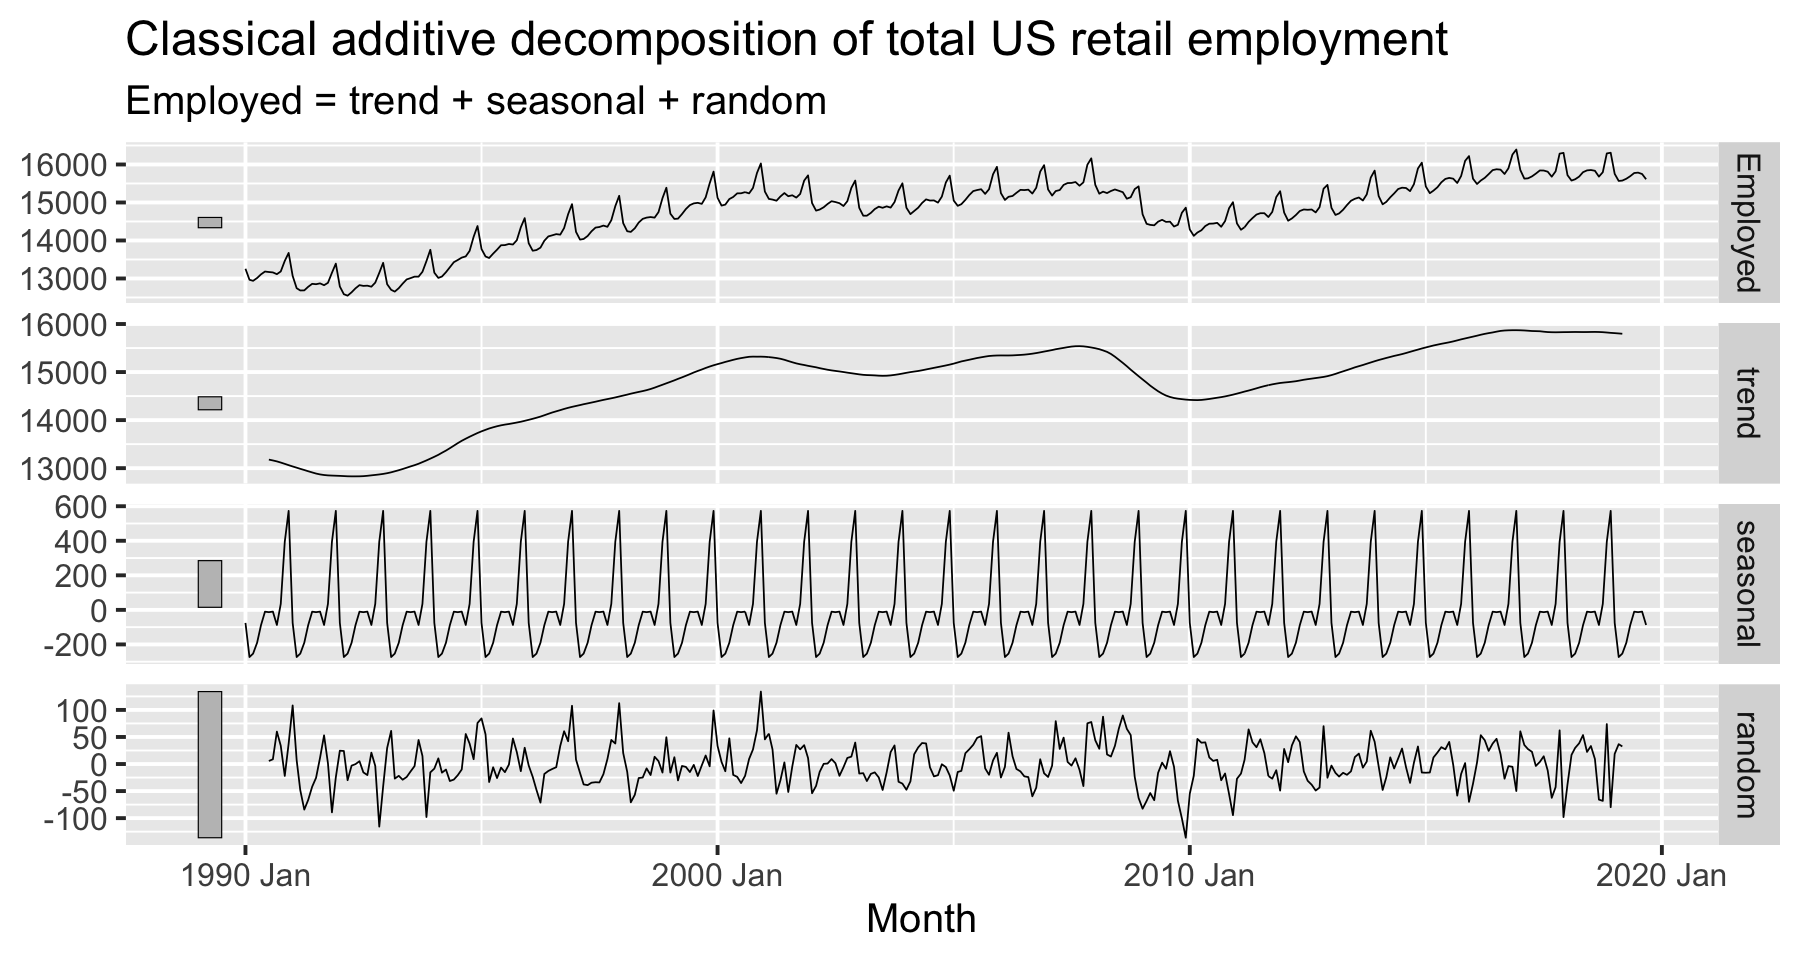

In [58]:
options(repr.plot.width=15, repr.plot.height=8)
theme_set(theme_gray(base_size = 24))
us_employment |>
  filter(year(Month) >= 1990, Title == "Retail Trade") |>
  select(-Series_ID) |>
  model(
    classical_decomposition(Employed, type = "additive")
  ) |>
  components() |>
  autoplot() +
  labs(title = "Classical additive decomposition of total US retail employment") 

Quiz: What does the grey bar mean?

> The grey bars to the left of each panel show the relative scales of the components. Each grey bar represents the same length but because the plots are on different scales, the bars vary in size. The large grey bar in the bottom panel shows that the variation in the remainder component is smallest compared to the variation in the data. If we shrank the bottom three panels until their bars became the same size as that in the data panel, then all the panels would be on the same scale.

## 3.1 Transformation and Adjustment

Adjusting the historical data can often lead to a simpler time series. Here, we deal with four kinds of adjustments: 

1. calendar adjustments
2. population adjustments
3. inflation adjustments
4.  mathematical transformations

The purpose of these adjustments and transformations is to simplify the patterns in the historical data by **removing known sources of variation, or by making the pattern more consistent across the whole data set**. Simpler patterns are usually easier to model and lead to more accurate forecasts.


#### Calendar adjustments

Some of the variation seen in seasonal data may be due to simple calendar effects. In such cases, it is usually much easier to remove the variation before doing any further analysis.

For example, February has fewer days than other months. If you are studying the total monthly sales in a retail store, there will be variation between the months simply because of the different numbers of trading days in each month, in addition to the seasonal variation across the year. It is easy to remove this variation by computing average sales per trading day in each month, rather than total sales in the month. Then we effectively remove the calendar variation. 


#### Population adjustments

Any data that are affected by population changes can be adjusted to give per-capita data. That is, consider the data per person (or per thousand people, or per million people) rather than the total.


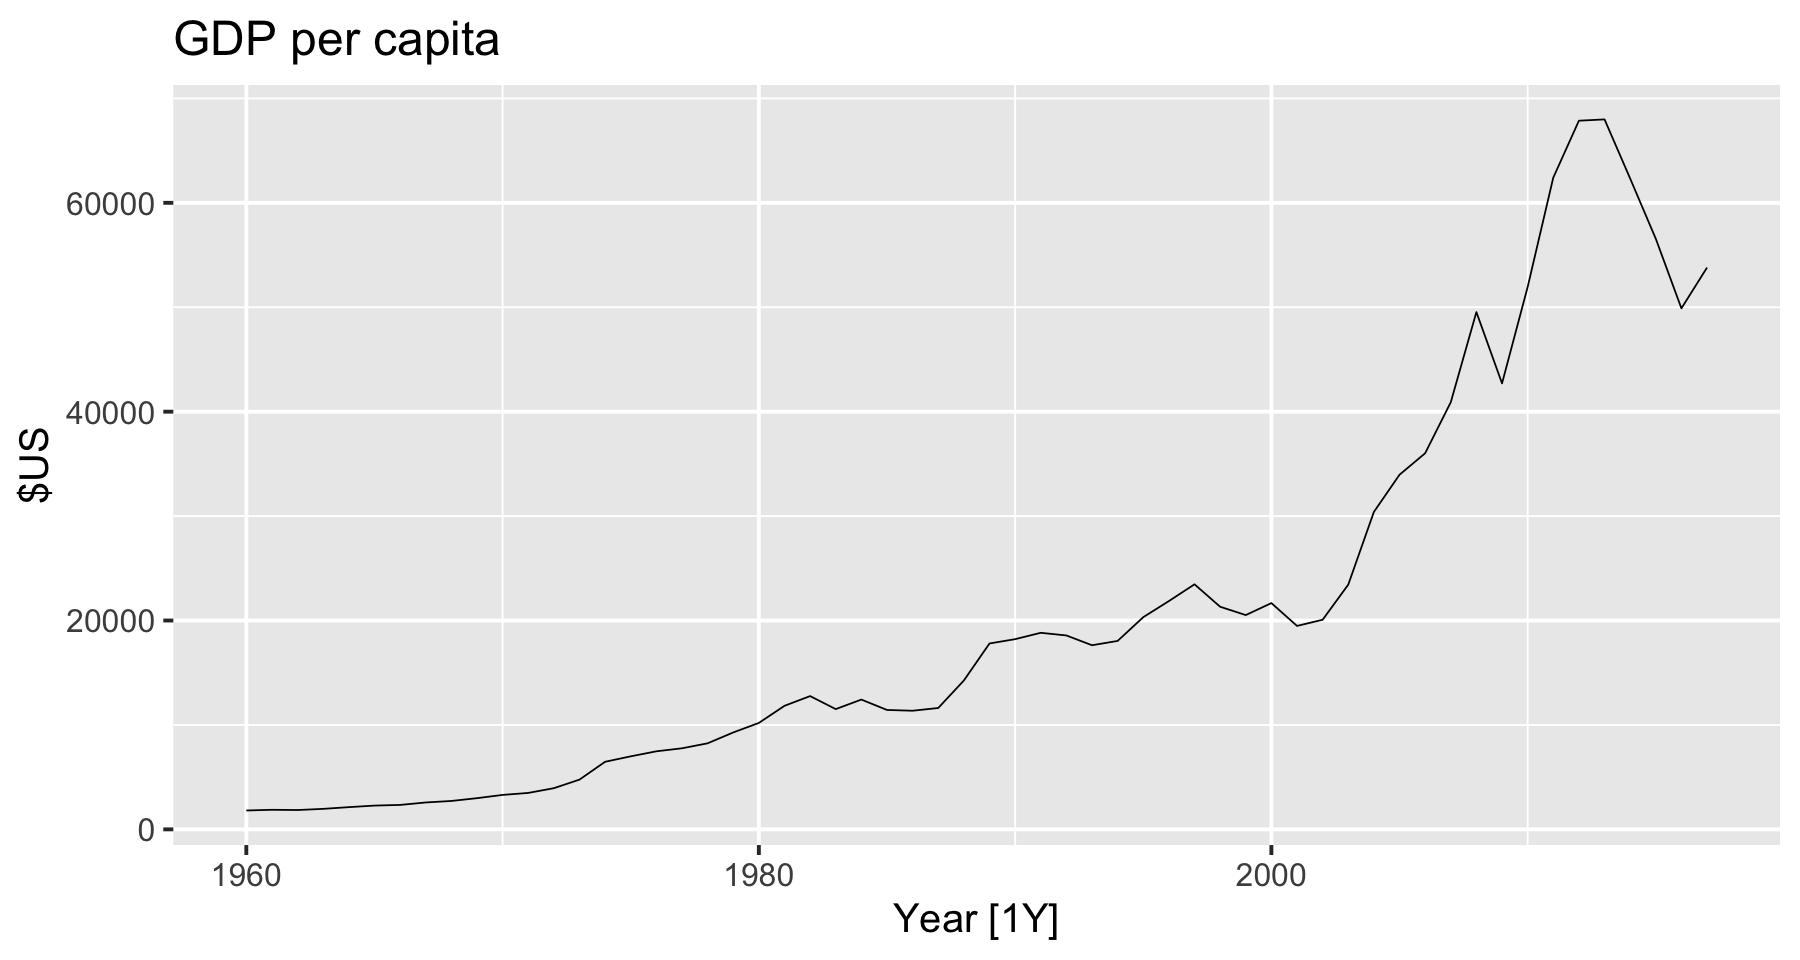

In [59]:
global_economy |>
  filter(Country == "Australia") |>
  autoplot(GDP/Population) +
  labs(title= "GDP per capita", y = "$US")

Here is an example that shows population adjustment makes a big difference.

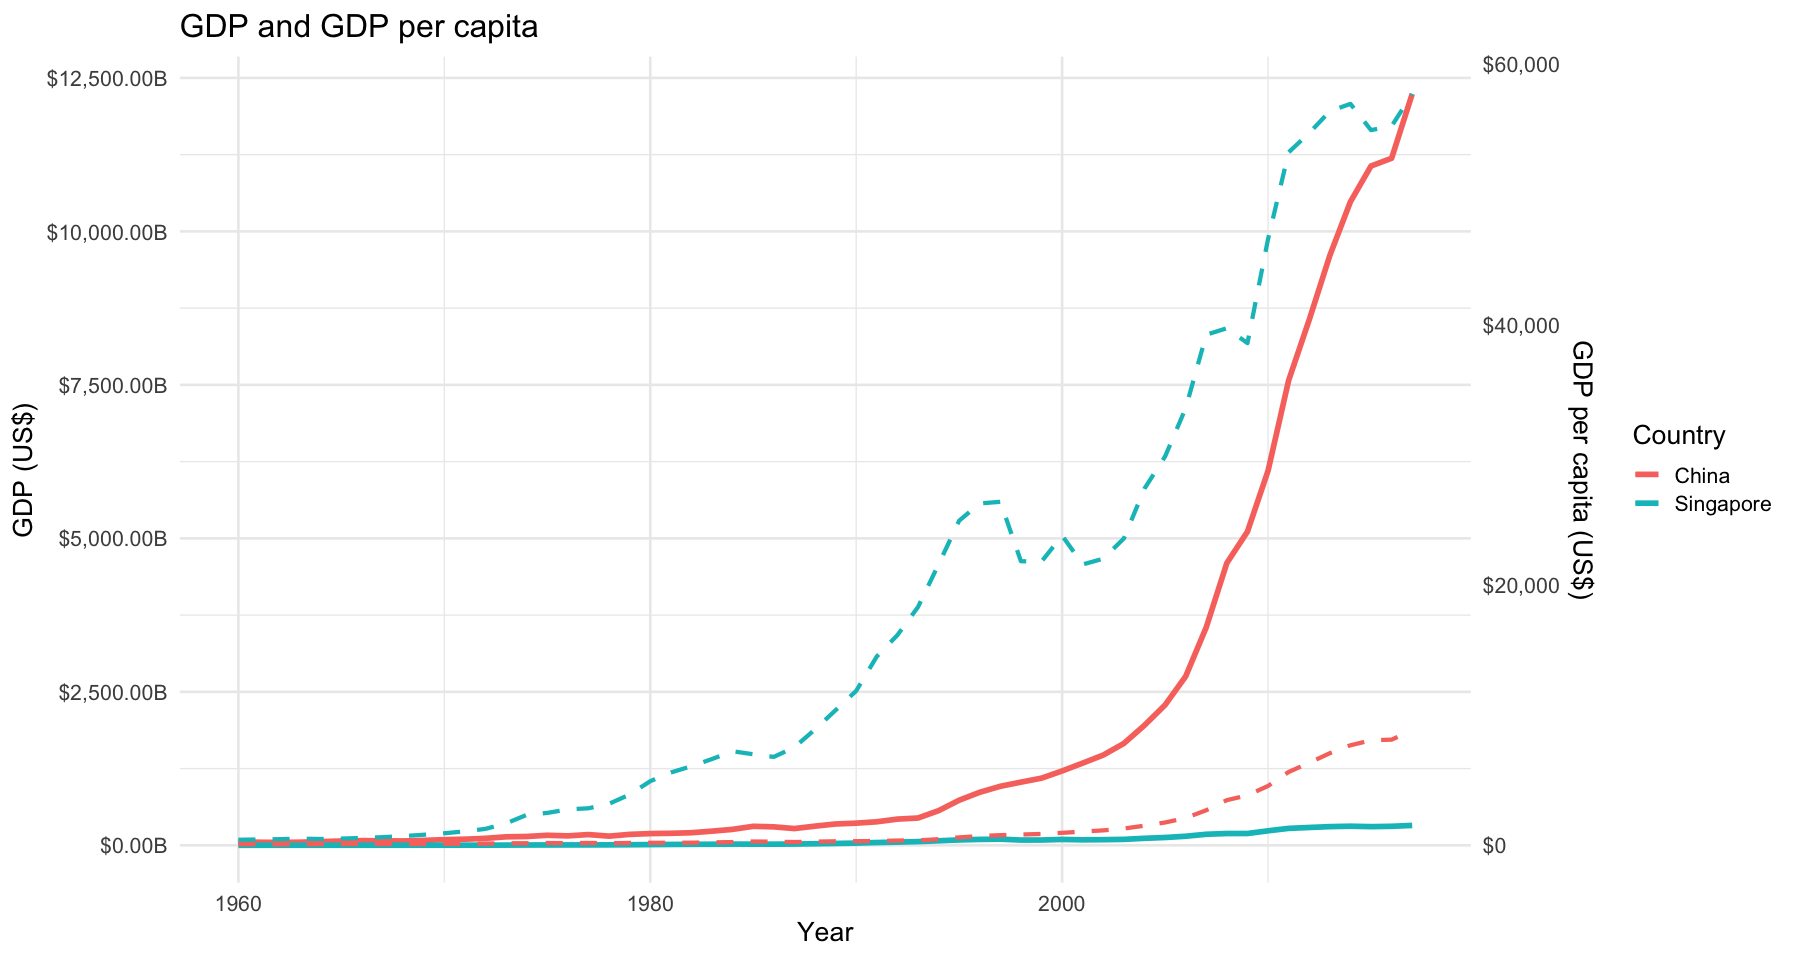

In [63]:
library(scales)
data <- global_economy |>
  filter(Country %in% c("China", "Singapore")) |>
  mutate(GDP_per_capita = GDP / Population)

coeff <- max(data$GDP, na.rm = TRUE) / max(data$GDP_per_capita, na.rm = TRUE)

ggplot(data, aes(x = Year, color = Country)) +
  geom_line(aes(y = GDP), size = 1.6) +
  geom_line(aes(y = GDP_per_capita * coeff), linetype = "dashed", size = 1.2) +
  scale_y_continuous(
    name = "GDP (US$)",
    labels = scales::dollar_format(scale = 1e-9, suffix = "B"),
    sec.axis = sec_axis(~./coeff, name = "GDP per capita (US$)", 
                        labels = scales::dollar_format())
  ) +
  labs(title = "GDP and GDP per capita",
       x = "Year") +
  theme_minimal(base_size = 16)+ 
  scale_linetype_manual(name = "Measure", 
                               values = c("solid", "dashed"),
                               labels = c("GDP", "GDP per capita"))

#### Inflation adjustments

Data which are affected by the value of money are best adjusted before modelling. For example, the average cost of a new house will have increased over the last few decades due to inflation. A \\$200,000 house this year is not the same as a \\$200,000 house twenty years ago. For this reason, financial time series are usually adjusted so that all values are stated in dollar values from a particular year. 


Warning message:
“Removed 1 row containing missing values or values outside the scale range (`geom_line()`).”


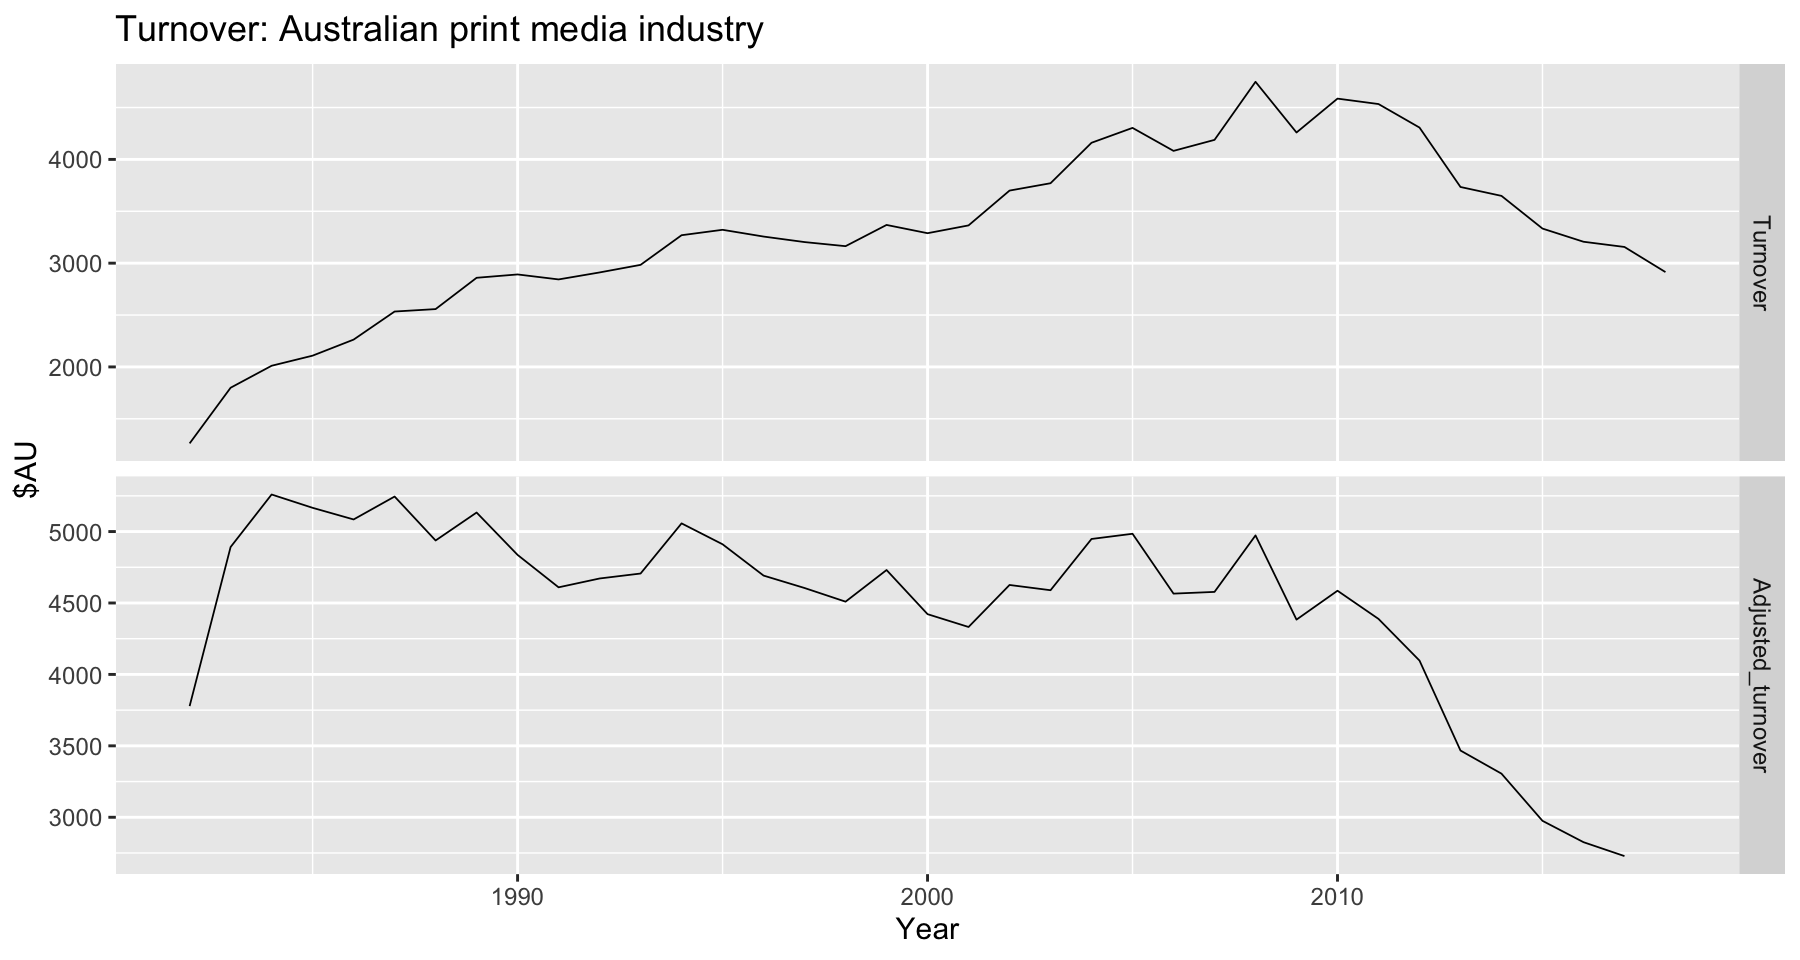

In [64]:
print_retail <- aus_retail |>
  filter(Industry == "Newspaper and book retailing") |>
  group_by(Industry) |>
  index_by(Year = year(Month)) |>
  summarise(Turnover = sum(Turnover))
aus_economy <- global_economy |>
  filter(Code == "AUS")

print_retail |>
  left_join(aus_economy, by = "Year") |>
  mutate(Adjusted_turnover = Turnover / CPI * 100) |> # This is where the adjustment is made
  pivot_longer(c(Turnover, Adjusted_turnover),
               values_to = "Turnover") |>
  mutate(name = factor(name,
         levels=c("Turnover","Adjusted_turnover"))) |>
  ggplot(aes(x = Year, y = Turnover)) +
  geom_line() +
  facet_grid(name ~ ., scales = "free_y") +
  labs(title = "Turnover: Australian print media industry",
       y = "$AU")

> Business **turnover** is the complete sum of sales made over a given period.


By adjusting for inflation using the CPI, we can see that Australia’s newspaper and book retailing industry has been in decline much longer than the original data suggests. The adjusted turnover is in 2010 Australian dollars, as CPI is 100 in 2010 in this data set.

### Mathematical transformations

If the data shows variation that increases or decreases with the level of the series, then a transformation can be useful.

#### Logarithmic transformation
Logarithmic transformation is often useful. If we denote the original observations as $y_1, \cdots , y_T$ and the transformed observations as $w_1, \cdots, w_T$, then $w_t = log(y_t)$.

#### Power transformation

Sometimes other transformations are also used (although they are not so interpretable). For example, square roots and cube roots can be used. These are called power transformations because they can be written in the form $w_t = y_t^p$.

#### Box-Cox transformation

$$
  w_t  =
    \begin{cases}
      \log(y_t) & \text{if $\lambda=0$};  \\
      (\text{sign}(y_t)|y_t|^\lambda-1)/\lambda & \text{otherwise}.
    \end{cases}
$$

The logarithm in a Box-Cox transformation is always a natural logarithm (i.e., to base $e$). So if $\lambda = 0$, natural logarithms are used, but if $\lambda \neq 0$, a power transformation is used, followed by some simple scaling.

If $\lambda =0$, then $w_t = y_t -1$, so the transformed data is shifted downwards but there is no change in the shape of the time series. For all other values of $\lambda$ the time series will change shape.

> The [example](https://otexts.com/fpp3/transformations.html#mathematical-transformations) on the fpp3 website is built using `Shiny` and I strongly suggest you to take a look at this package :).

A good value of $\lambda$ is one which makes the size of the seasonal variation about the same across the whole series, as that makes the forecasting model simpler.

The `guerrero` feature (Guerrero, 1993) can be used to choose a value of lambda for you.

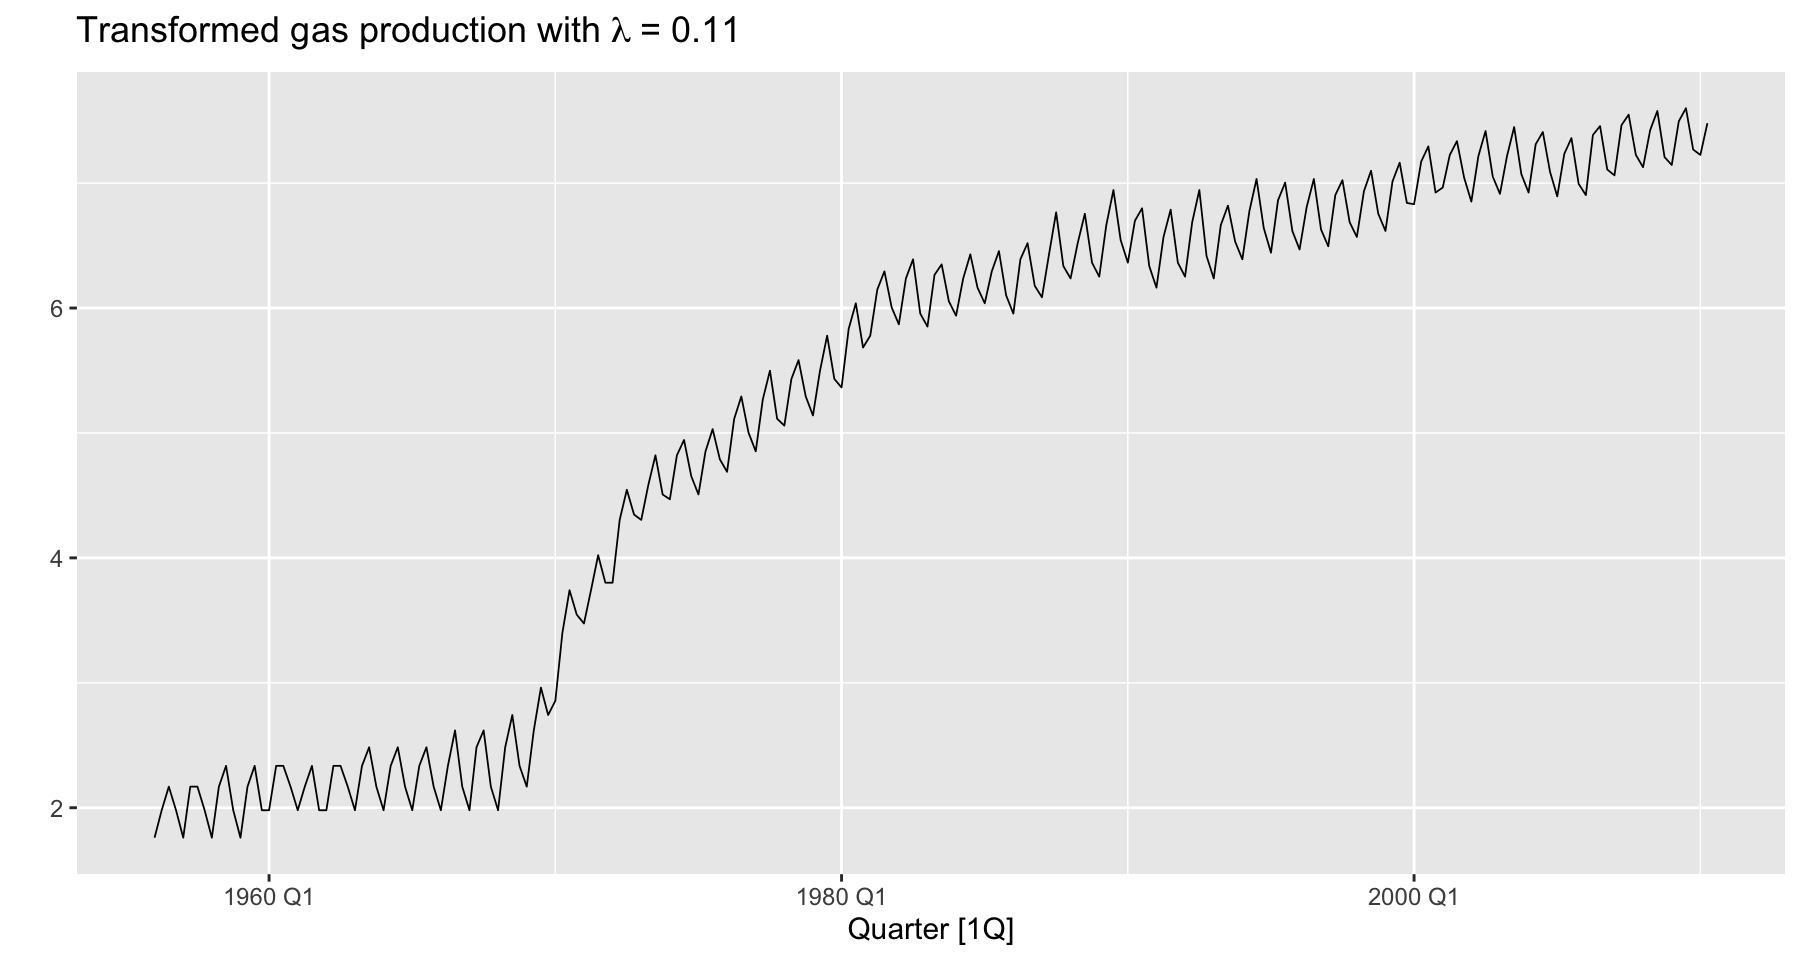

In [66]:
lambda <- aus_production |>
  features(Gas, features = guerrero) |>
  pull(lambda_guerrero)
aus_production |>
  autoplot(box_cox(Gas, lambda)) +
  labs(y = "",
       title = latex2exp::TeX(paste0(
         "Transformed gas production with $\\lambda$ = ",
         round(lambda,2))))

## 3.2 Time series components

### The `equivalence` of additive decomposition and multiplicative decomposition
If we assume an additive decomposition, then we can write
$$y_{t} = S_{t} + T_{t} + R_t$$

where $y_t$ is the data,  $S_t$ is the seasonal component, $T_t$ is the trend-cycle component, and $R_t$ is the remainder component, all at period $t$. Alternatively, a multiplicative decomposition would be written as

$$y_{t} = S_{t} \times T_{t} \times R_t$$

However, by taking the logarithm, we see that

$$y_{t} = S_{t} \times T_{t} \times R_t \quad\text{is equivalent to}\quad
  \log y_{t} = \log S_{t} + \log T_{t} + \log R_t.$$

### Example: Employment in the US retail sector

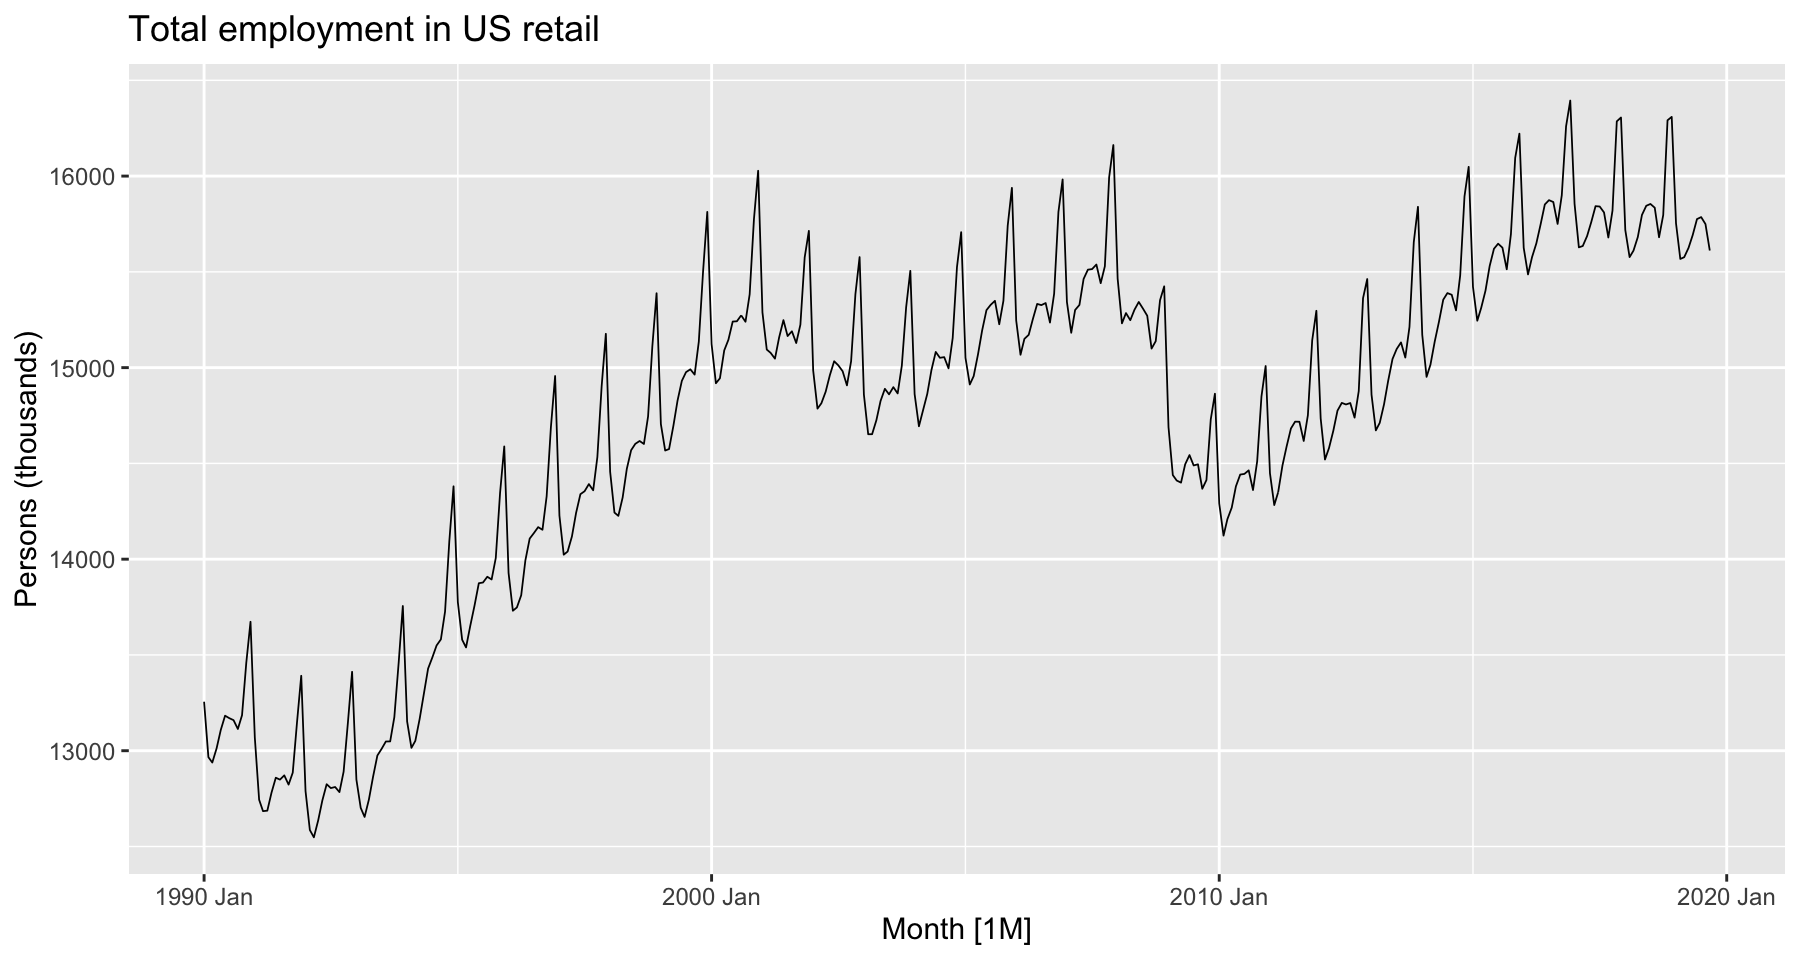

In [67]:
us_retail_employment <- us_employment |>
  filter(year(Month) >= 1990, Title == "Retail Trade") |>
  select(-Series_ID)
autoplot(us_retail_employment, Employed) +
  labs(y = "Persons (thousands)",
       title = "Total employment in US retail")

To illustrate the ideas, we will use the STL (Seasonal-Trend decomposition using LOESS) decomposition method. It is a robust method of time series decomposition often used in economic and environmental analyses.

In [49]:
dcmp <- us_retail_employment |>
  model(stl = STL(Employed))
components(dcmp) |> head()

.model Month    Employed trend    season_year remainder   season_adjust
1 stl    1990 Jan 13255.8  13288.01  -33.04706    0.8358973 13288.85     
2 stl    1990 Feb 12966.3  13269.10 -258.19042  -44.6052068 13224.49     
3 stl    1990 Mar 12938.2  13250.18 -289.87277  -22.1073302 13228.07     
4 stl    1990 Apr 13012.3  13231.26 -220.01752    1.0529563 13232.32     
5 stl    1990 May 13108.3  13211.41 -114.39559   11.2815978 13222.70     
6 stl    1990 Jun 13182.8  13191.56  -24.26610   15.5026778 13207.07

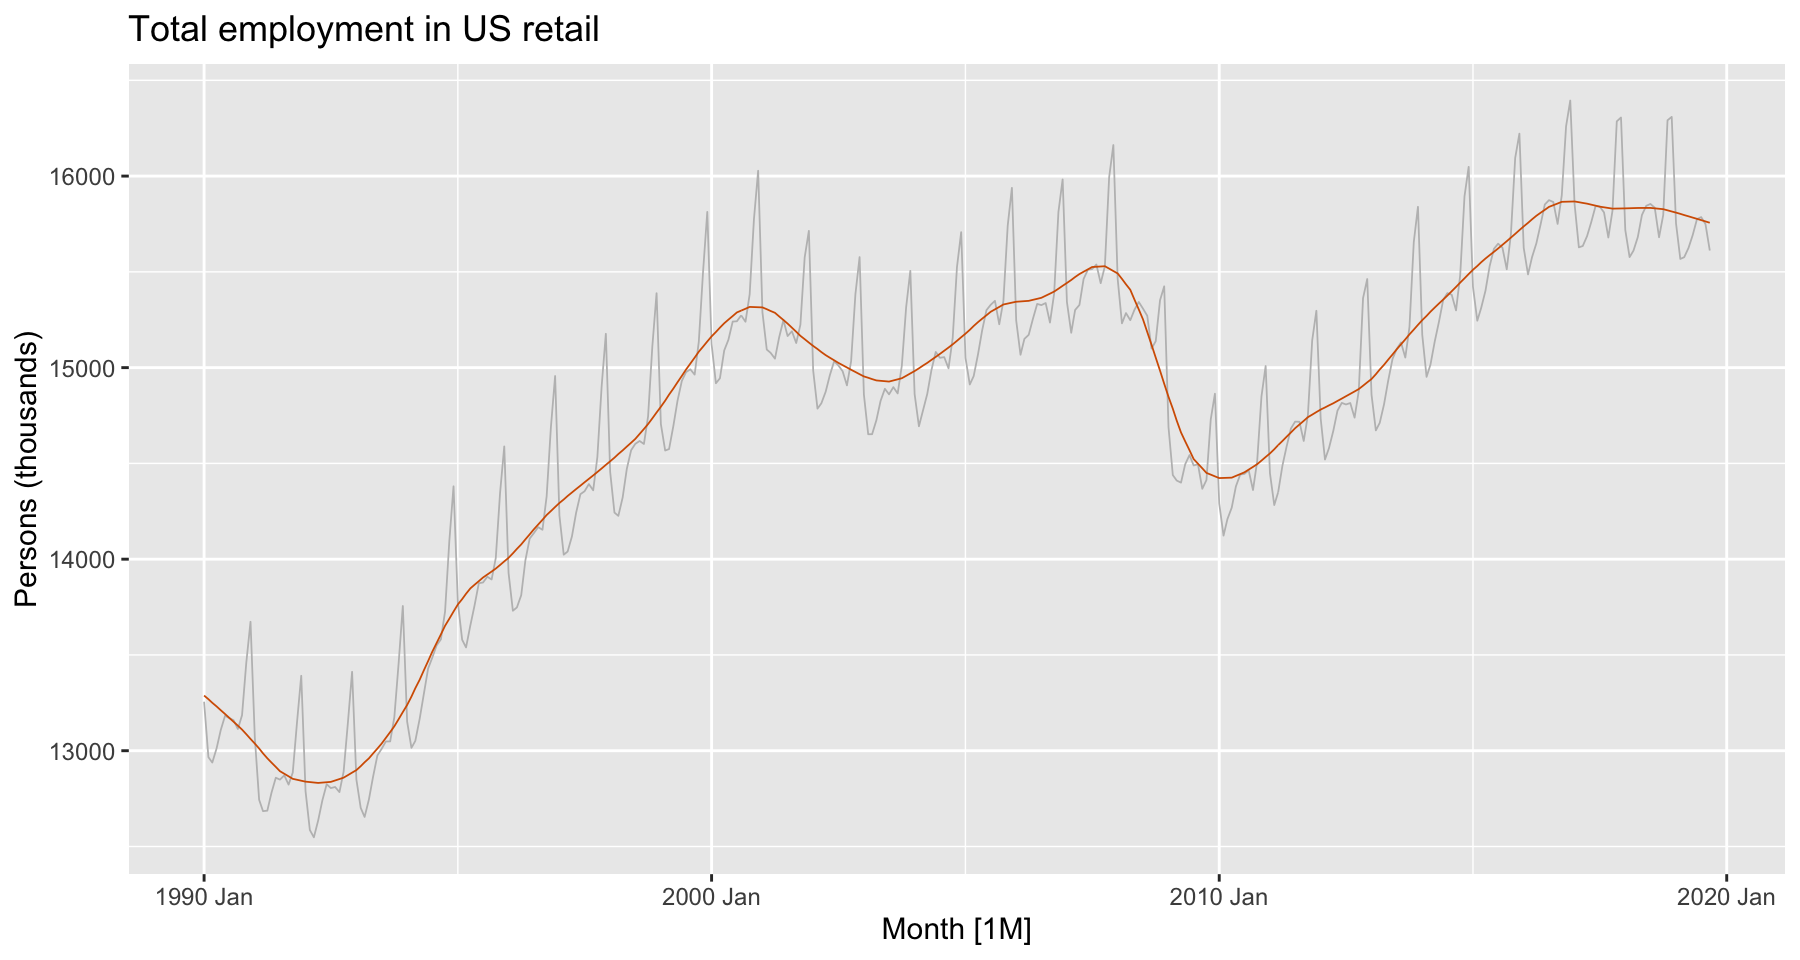

In [68]:
components(dcmp) |>
  as_tsibble() |>
  autoplot(Employed, colour="gray") +
  geom_line(aes(y=trend), colour = "#D55E00") +
  labs(
    y = "Persons (thousands)",
    title = "Total employment in US retail"
  )

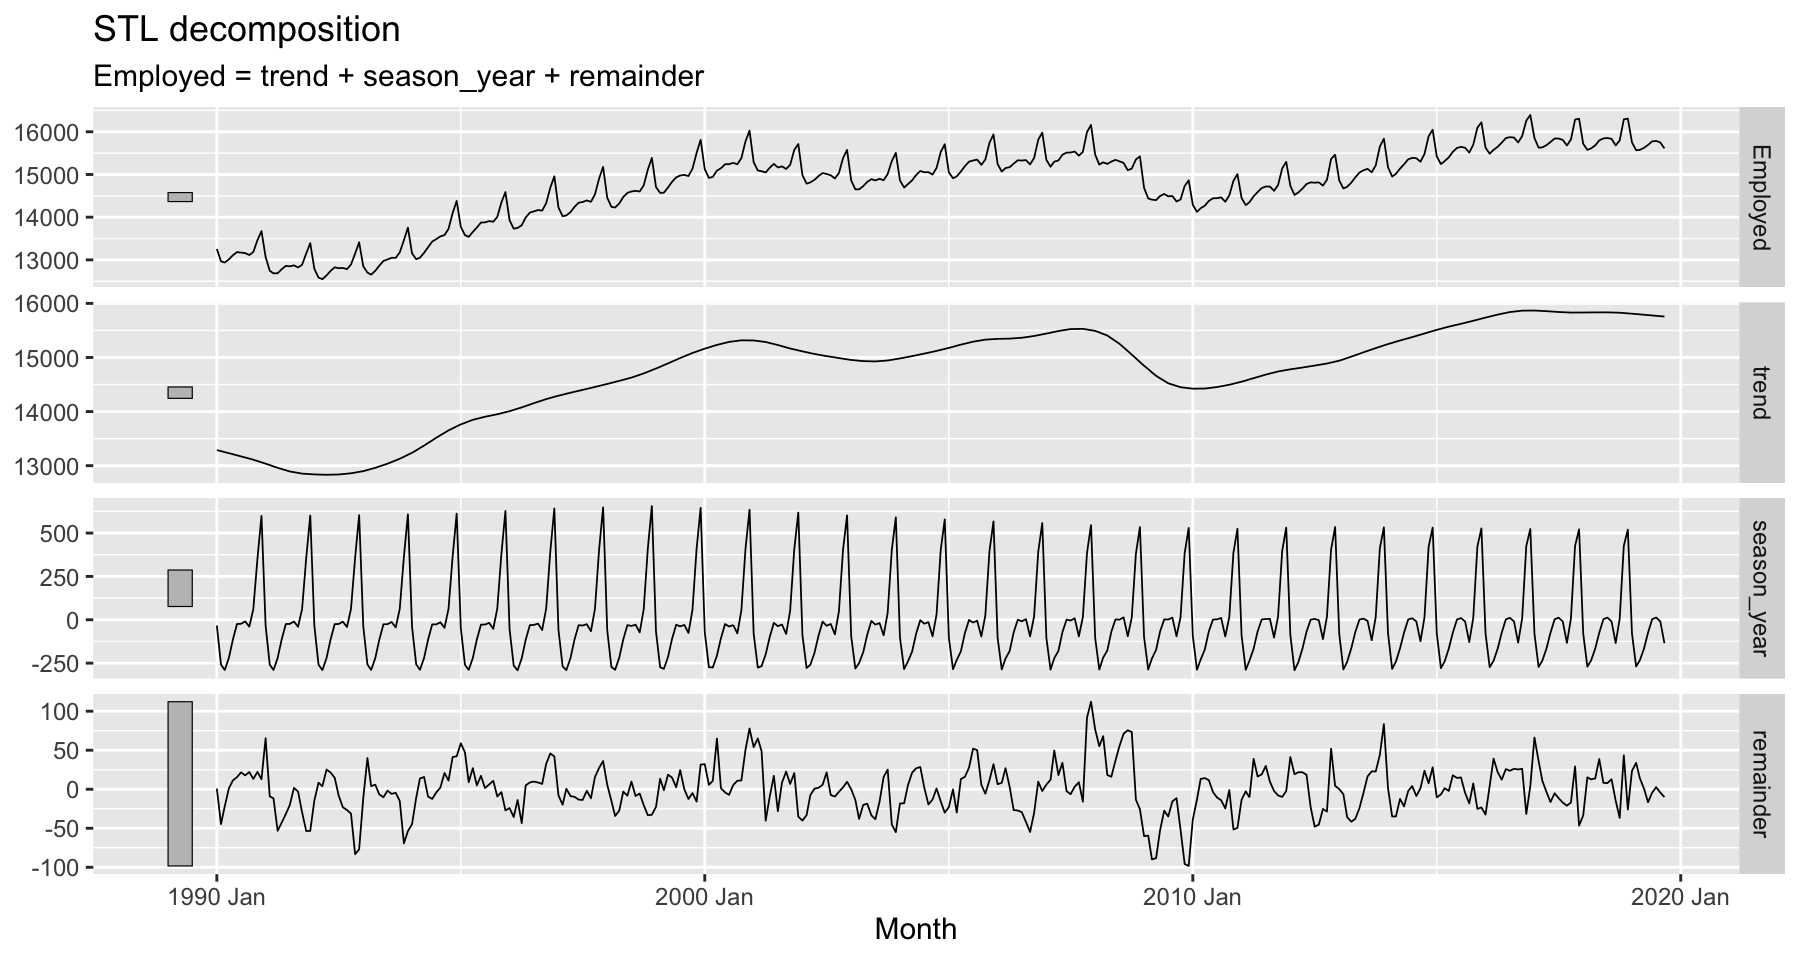

In [69]:
components(dcmp) |> autoplot()

### Seasonally adjusted data

If the seasonal component is removed from the original data, the resulting values are the “seasonally adjusted” data. For an additive decomposition, the seasonally adjusted data are given by $y_t - S_t$, and for multiplicative data, the seasonally adjusted values are obtained using $\frac{y_t}{S_t}$.

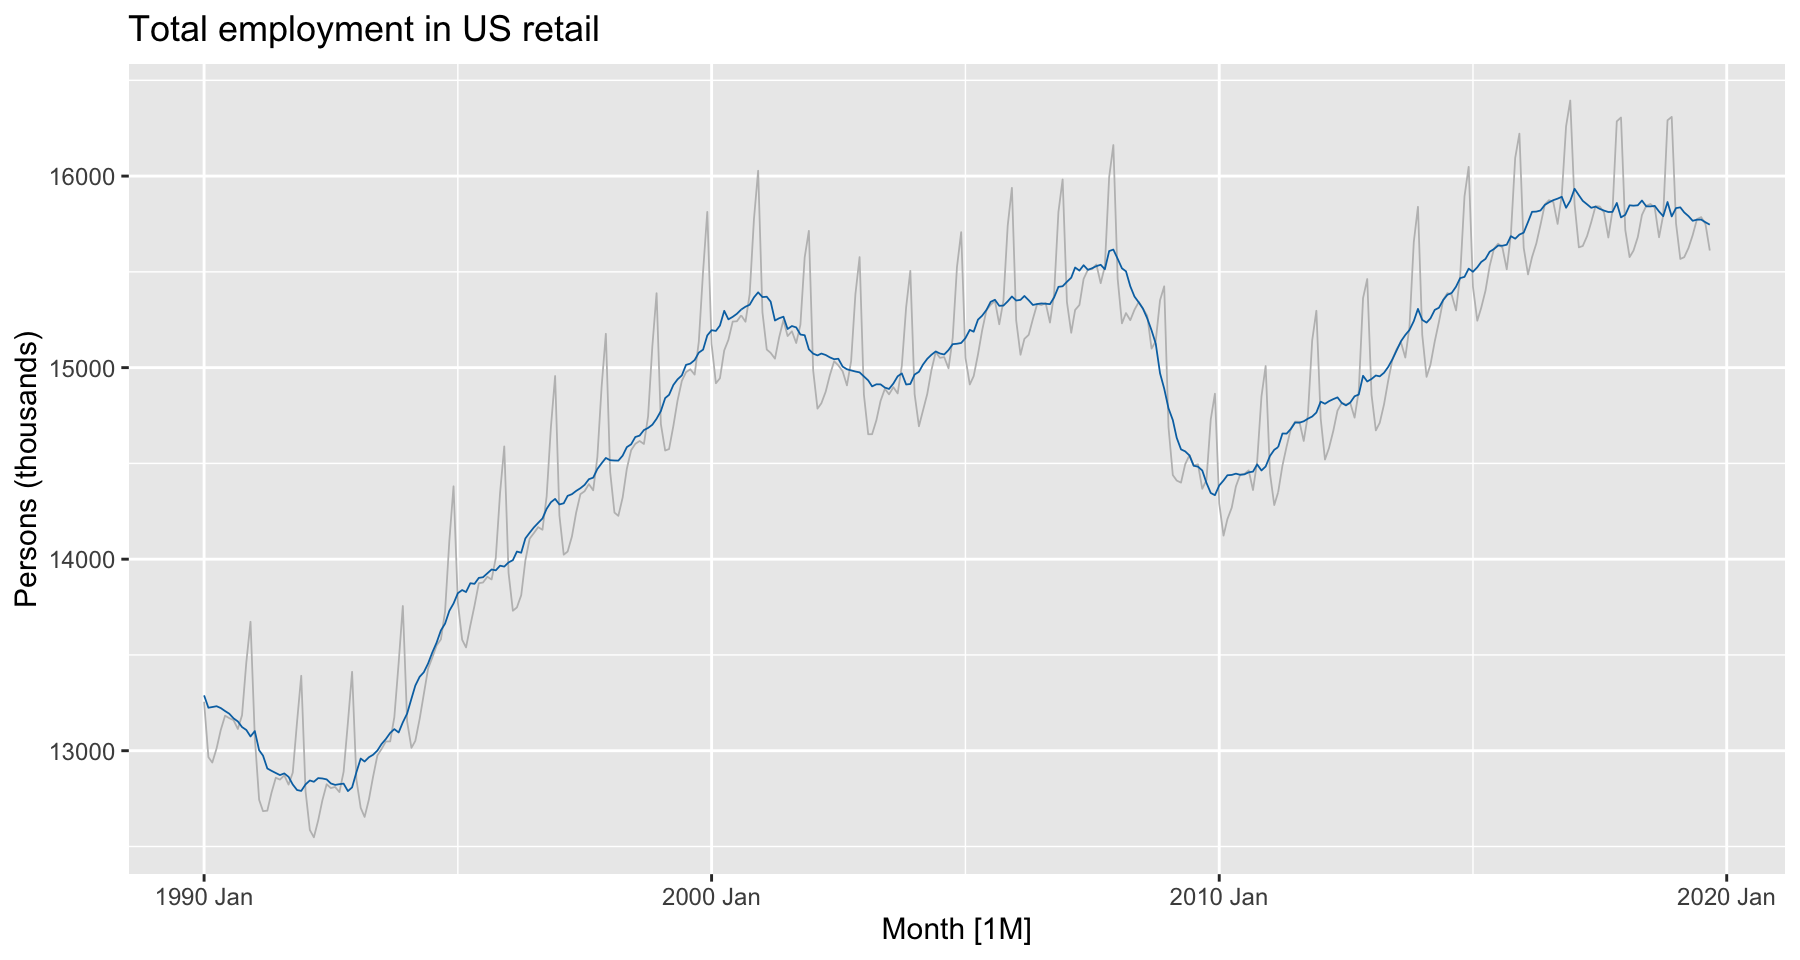

In [70]:
components(dcmp) |>
  as_tsibble() |>
  autoplot(Employed, colour = "gray") +
  geom_line(aes(y=season_adjust), colour = "#0072B2") +
  labs(y = "Persons (thousands)",
       title = "Total employment in US retail")

## 3.3 Moving averages

How would you remove "seasonal" component from your data?

### The intuition of removing seasonal component

It is "seasonal" because there is a periodic pattern. If we can "smear" the fluctuation with some averaging operation, then we remove the seasonal component.

As we are dealing time series so the averaging must cover a moving window, large enough of course, therefore we need `moving average`.

### Moving Average Definition

A moving average of order $m$ an be written as

$$
  \hat{T}_{t} = \frac{1}{m} \sum_{j=-k}^k y_{t+j}
$$

where  $m=2k+1$. That is, the estimate of the trend-cycle at time $t$ is obtained by averaging values of the time series within $k$ periods of $t$. Observations that are nearby in time are also likely to be close in value. Therefore, the average eliminates some of the randomness in the data, leaving a smooth trend-cycle component. We call this an $m-MA$, meaning a moving average of order $m$.

> If you are trading stocks, this formula is disastrously problematic, why?

### Example: Total Australian Exports

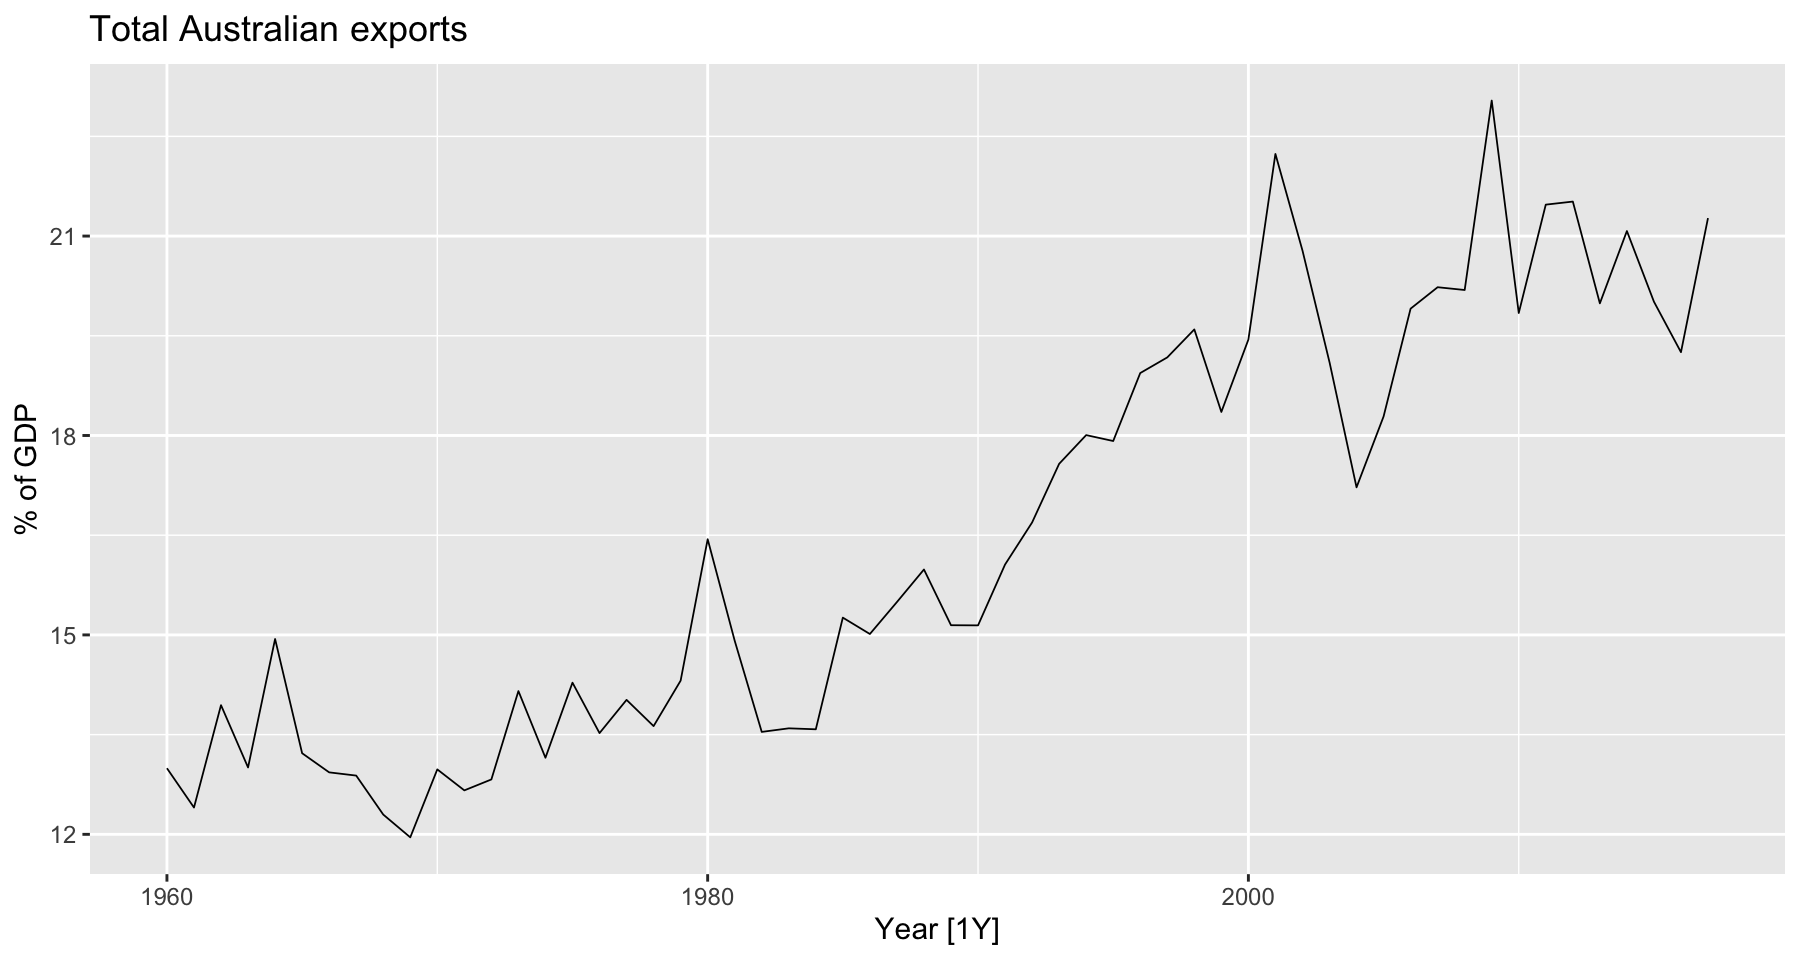

In [71]:
global_economy |>
  filter(Country == "Australia") |>
  autoplot(Exports) +
  labs(y = "% of GDP", title = "Total Australian exports")

The moving average is easily computed using `slide_dbl()` from the `slider` package which applies a function to “sliding” time windows. In this case, we use the mean() function with a window of size 5.

Warning message:
“Removed 4 rows containing missing values or values outside the scale range (`geom_line()`).”


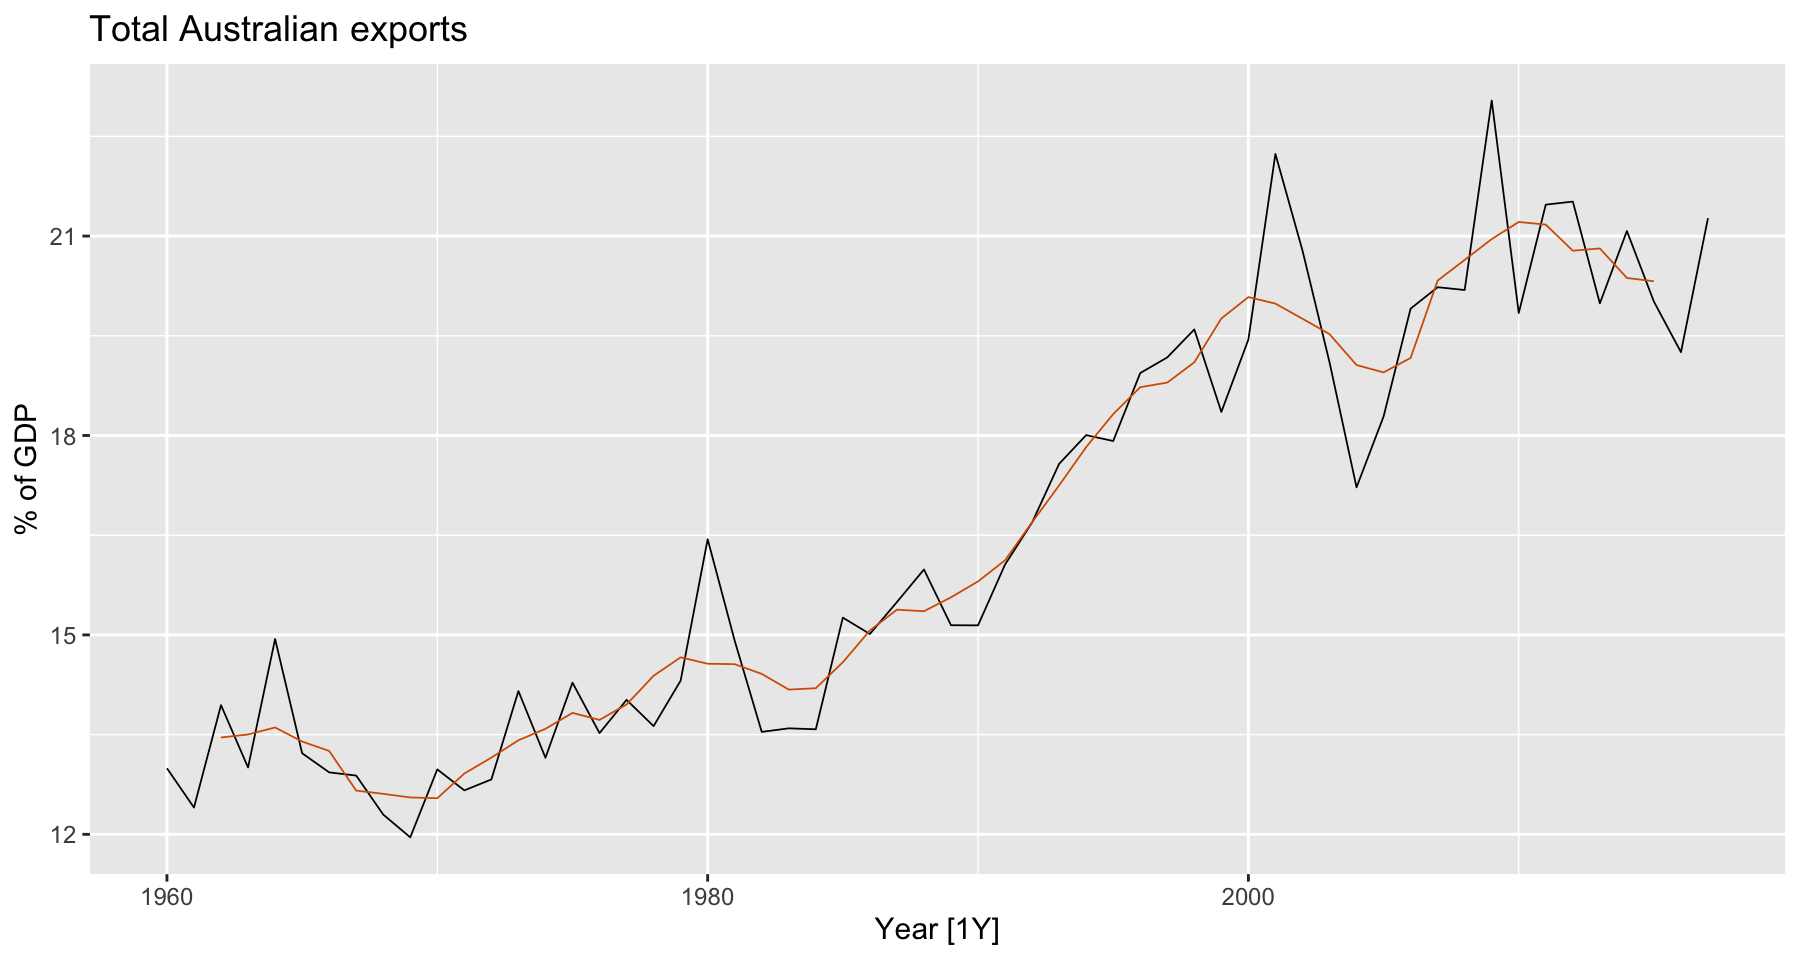

In [73]:
aus_exports <- global_economy |>
  filter(Country == "Australia") |>
  mutate(
    `5-MA` = slider::slide_dbl(Exports, mean, # namespace used here, quiz, why do we need to Backtick "`" for the name?
                .before = 2, .after = 2, .complete = TRUE) #quiz, what's the meaning of .complete? use ?slide_dbl to find out.
  )
aus_exports |>
  autoplot(Exports) +
  geom_line(aes(y = `5-MA`), colour = "#D55E00") +
  labs(y = "% of GDP",
       title = "Total Australian exports")

Different window sizes have different `smoothing` power.

Warning message:
“Removed 2 rows containing missing values or values outside the scale range (`geom_line()`).”
Warning message:
“Removed 4 rows containing missing values or values outside the scale range (`geom_line()`).”
Warning message:
“Removed 6 rows containing missing values or values outside the scale range (`geom_line()`).”
Warning message:
“Removed 8 rows containing missing values or values outside the scale range (`geom_line()`).”


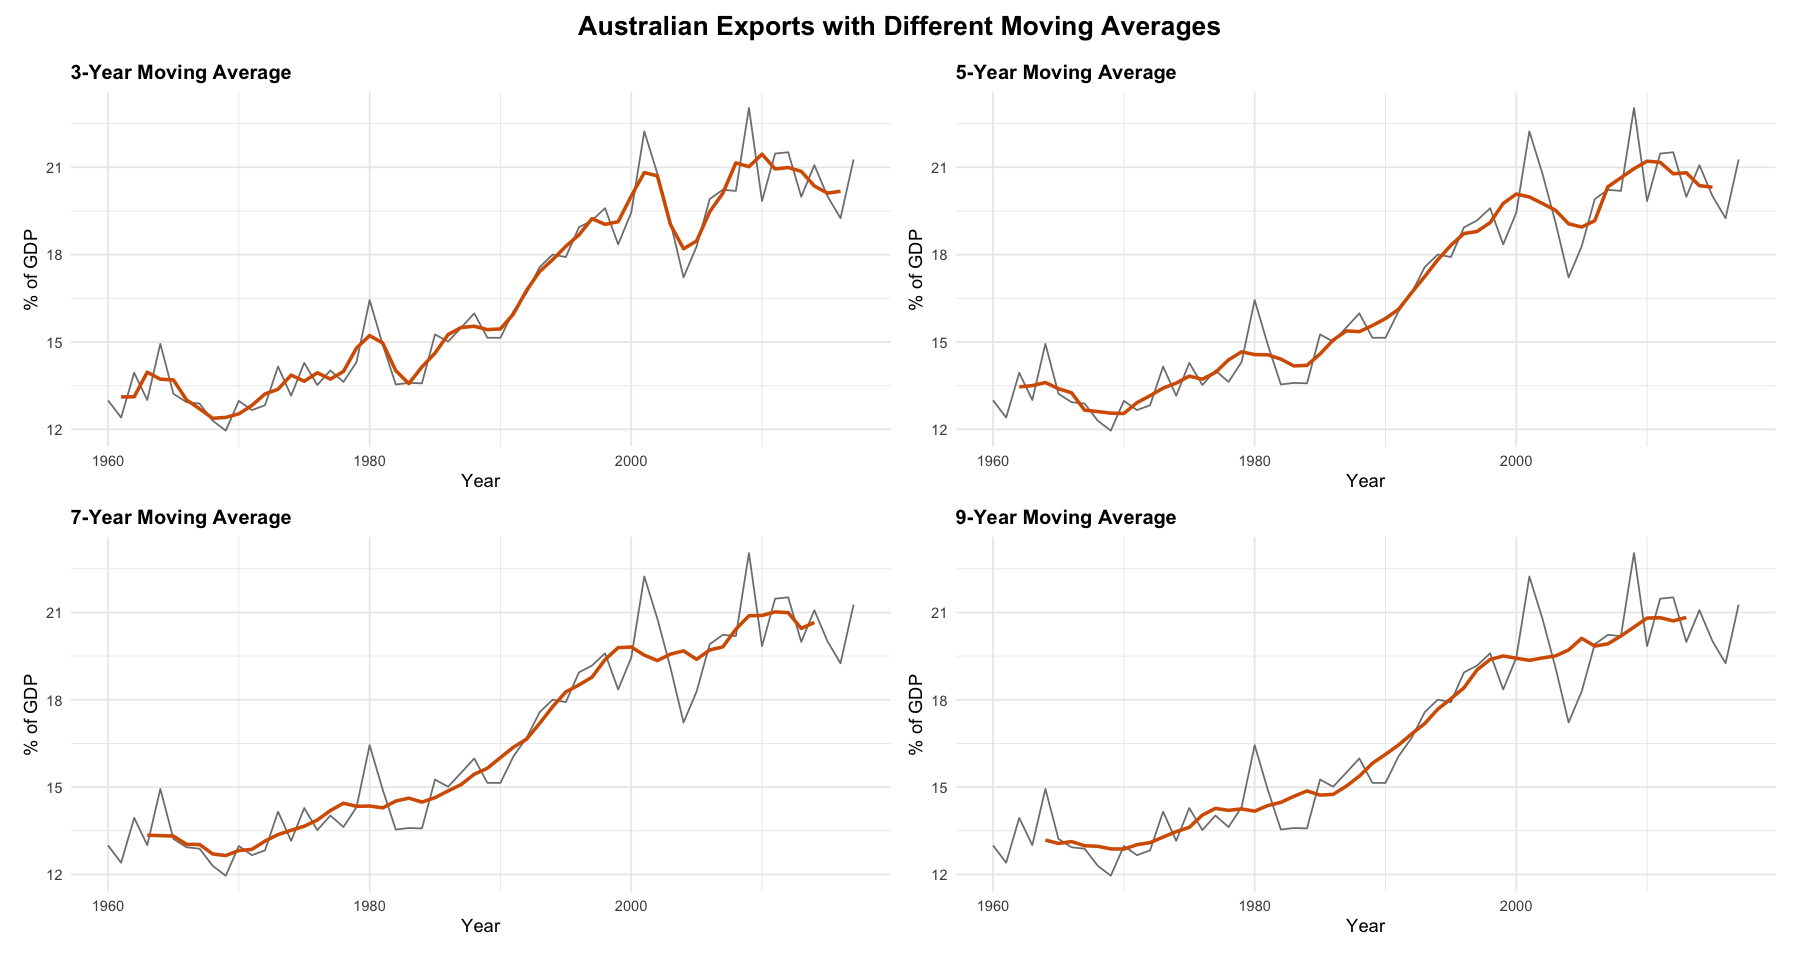

In [80]:
library(patchwork)
aus_exports <- global_economy |>
  filter(Country == "Australia") |>
  mutate(
    `3-MA` = slider::slide_dbl(Exports, mean, 
                .before = 1, .after = 1, .complete = TRUE),
    `5-MA` = slider::slide_dbl(Exports, mean, 
                .before = 2, .after = 2, .complete = TRUE),
    `7-MA` = slider::slide_dbl(Exports, mean, 
                .before = 3, .after = 3, .complete = TRUE),
    `9-MA` = slider::slide_dbl(Exports, mean, 
                .before = 4, .after = 4, .complete = TRUE)
  )

# Function to create individual plots
create_plot <- function(data, ma_col, title) {
  ggplot(data, aes(x = Year)) +
    geom_line(aes(y = Exports), colour = "grey50") +
    geom_line(aes(y = .data[[ma_col]]), colour = "#D55E00", size = 1) +
    labs(y = "% of GDP",
         title = title) +
    theme_minimal() +
    theme(plot.title = element_text(size = 12, face = "bold"))
}

# Create individual plots
p1 <- create_plot(aus_exports, "3-MA", "3-Year Moving Average")
p2 <- create_plot(aus_exports, "5-MA", "5-Year Moving Average")
p3 <- create_plot(aus_exports, "7-MA", "7-Year Moving Average")
p4 <- create_plot(aus_exports, "9-MA", "9-Year Moving Average")

# Combine plots into a 2x2 grid
(p1 + p2) / (p3 + p4) + # patchwork syntax
  plot_annotation(
    title = "Australian Exports with Different Moving Averages",
    theme = theme(plot.title = element_text(size = 16, face = "bold", hjust = 0.5))
  )

### Moving averages of moving averages

It is possible to apply a moving average to a moving average.

For example, we might take a moving average of order 4, and then apply another moving average of order 2 to the results. In the following table, this has been done for the first few years of the Australian quarterly beer production data.

In [82]:
beer <- aus_production |>
  filter(year(Quarter) >= 1992) |>
  select(Quarter, Beer)
beer_ma <- beer |>
  mutate(
    `4-MA` = slider::slide_dbl(Beer, mean,
                .before = 1, .after = 2, .complete = TRUE),
    `2x4-MA` = slider::slide_dbl(`4-MA`, mean,
                .before = 1, .after = 0, .complete = TRUE)
  )
beer_ma |> head()

Quarter Beer 4-MA   2x4-MA 
1 1992 Q1 443      NA      NA
2 1992 Q2 410  451.25      NA
3 1992 Q3 420  448.75 450.000
4 1992 Q4 532  451.50 450.125
5 1993 Q1 433  449.00 450.250
6 1993 Q2 421  444.00 446.500

When a 2-MA follows a moving average of an even order (such as 4), it is called a “centred moving average of order 4”. This is because the results are now symmetric. To see that this is the case, we can write the $2\times4$-MA as follows:

$$\hat{T}_{t} = \frac{1}{2}\Big[
    \frac{1}{4} (y_{t-2}+y_{t-1}+y_{t}+y_{t+1}) +
    \frac{1}{4} (y_{t-1}+y_{t}+y_{t+1}+y_{t+2})\Big] 
             = \frac{1}{8}y_{t-2}+\frac14y_{t-1} +
             \frac14y_{t}+\frac14y_{t+1}+\frac18y_{t+2}
$$

It is now a weighted average of observations that is symmetric.

Other combinations of moving averages are also possible. For example, a $3\times3$-MA is often used, and consists of a moving average of order 3 followed by another moving average of order 3. In general, an even order MA should be followed by an even order MA to make it symmetric. Similarly, an odd order MA should be followed by an odd order MA.

> What's the benefit of the `weighted` average?

### Estimating the trend-cycle with seasonal data

Now, it is time to combine our intuition with math formula.

The most common use of centred moving averages is for estimating the trend-cycle from seasonal data. Consider the  $2\times4$-MA:

$$
\hat{T}_{t} = \frac{1}{8}y_{t-2} + \frac14y_{t-1} + \frac14y_{t} + \frac14y_{t+1} + \frac18y_{t+2}.
$$

When applied to quarterly data, each quarter of the year is given equal weight as the first and last terms apply to the same quarter in consecutive years. Consequently, the seasonal variation will be averaged out and the resulting values of $\hat{T_t}$ will have little or no seasonal variation remaining.

> Quiz: what's the pattern for the coefficients of a $2\times m$-MA expression?
> 
> Quiz: What should $m$ be if you want to remove weekly seasonality?

### Example: Employment in the US retail sector

Warning message:
“Removed 12 rows containing missing values or values outside the scale range (`geom_line()`).”


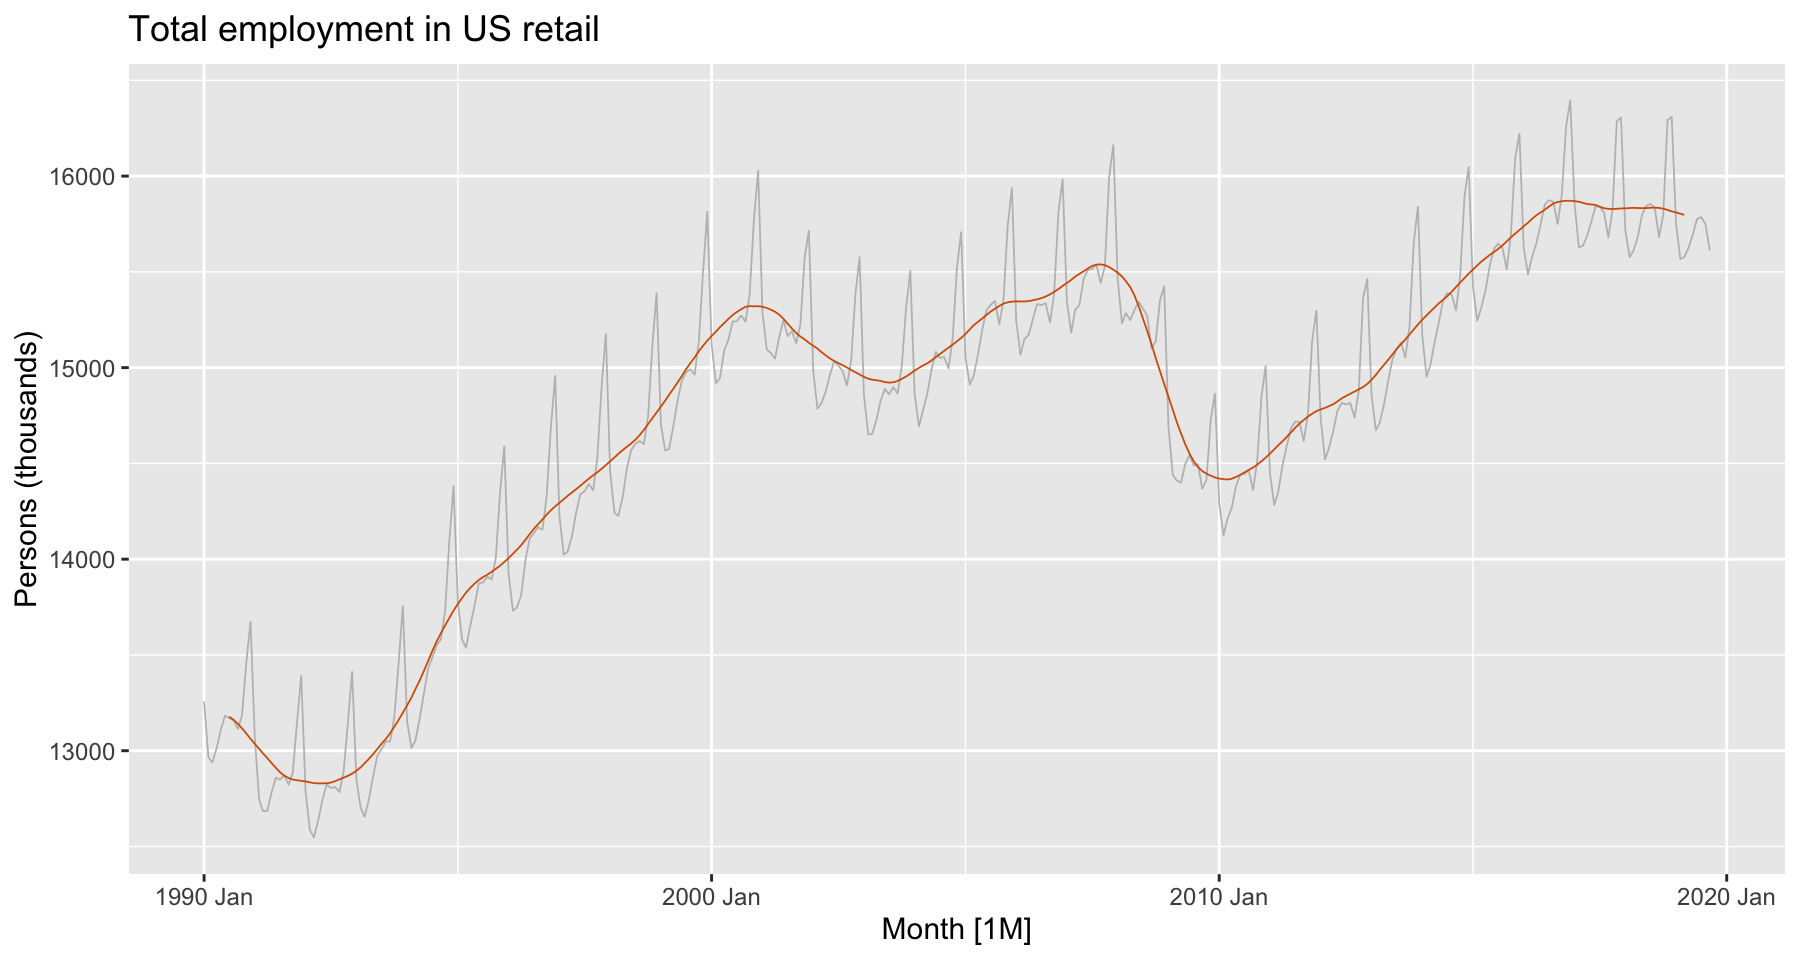

In [84]:
us_retail_employment_ma <- us_retail_employment |>
  mutate(
    `12-MA` = slider::slide_dbl(Employed, mean,
                .before = 5, .after = 6, .complete = TRUE),
    `2x12-MA` = slider::slide_dbl(`12-MA`, mean,
                .before = 1, .after = 0, .complete = TRUE)
  )
us_retail_employment_ma |>
  autoplot(Employed, colour = "gray") +
  geom_line(aes(y = `2x12-MA`), colour = "#D55E00") +
  labs(y = "Persons (thousands)",
       title = "Total employment in US retail")

### Weighted moving averages

Weighted moving average doesn't have to come from "nested" simple moving averages. In general a weighted `m-MA` can be written as 

$$\hat{T}_t = \sum_{j=-k}^k a_j y_{t+j}$$

where  $k=(m-1)/2$, and the weights are given by $[a_{-k},\cdots, a_k]$. It is important that the weights all sum to one and that they are symmetric so that $a_{-j}= a_{j}$. The simple `m-MA` is a special case where all of the weights are equal to  $\frac{1}{m}$.

A major advantage of weighted moving averages is that they yield a smoother estimate of the trend-cycle. Instead of observations entering and leaving the calculation at full weight, their weights slowly increase and then slowly decrease, resulting in a smoother curve.

> Quiz: why?

## 3.4 Classical decomposition

The classical decomposition method originated in the 1920s. It is a relatively simple procedure, and forms the starting point for most other methods of time series decomposition. 

### Additive decomposition

#### Step 1: Determine the seasonal period $m$.
If $m$ is an even number, compute the trend-cycle component $\hat{T}_t$ using a $2 \times m$-MA. If $m$ is 
an odd number, compute the trend-cycle component $\hat{T}_t$ using an $m$-MA.

#### Step 2: Detrend

Step 2
Calculate the detrended series:  $y_t-\hat{T}_t$

#### Step 3: Obtain $S_t$

To estimate the seasonal component for each season, simply average the detrended values for that season. For example, with monthly data, the seasonal component for March is the average of all the detrended March values in the data. These seasonal component values are then adjusted to ensure that they add to zero. The seasonal component is obtained by stringing together these monthly values, and then replicating the sequence for each year of data. 

#### Step 4: Obtain the remainder component

$$ \hat{R}_t = y_t - \hat{T}_t - \hat{S}_t$$

### US Retail Example

Warning message:
“Removed 6 rows containing missing values or values outside the scale range (`geom_line()`).”


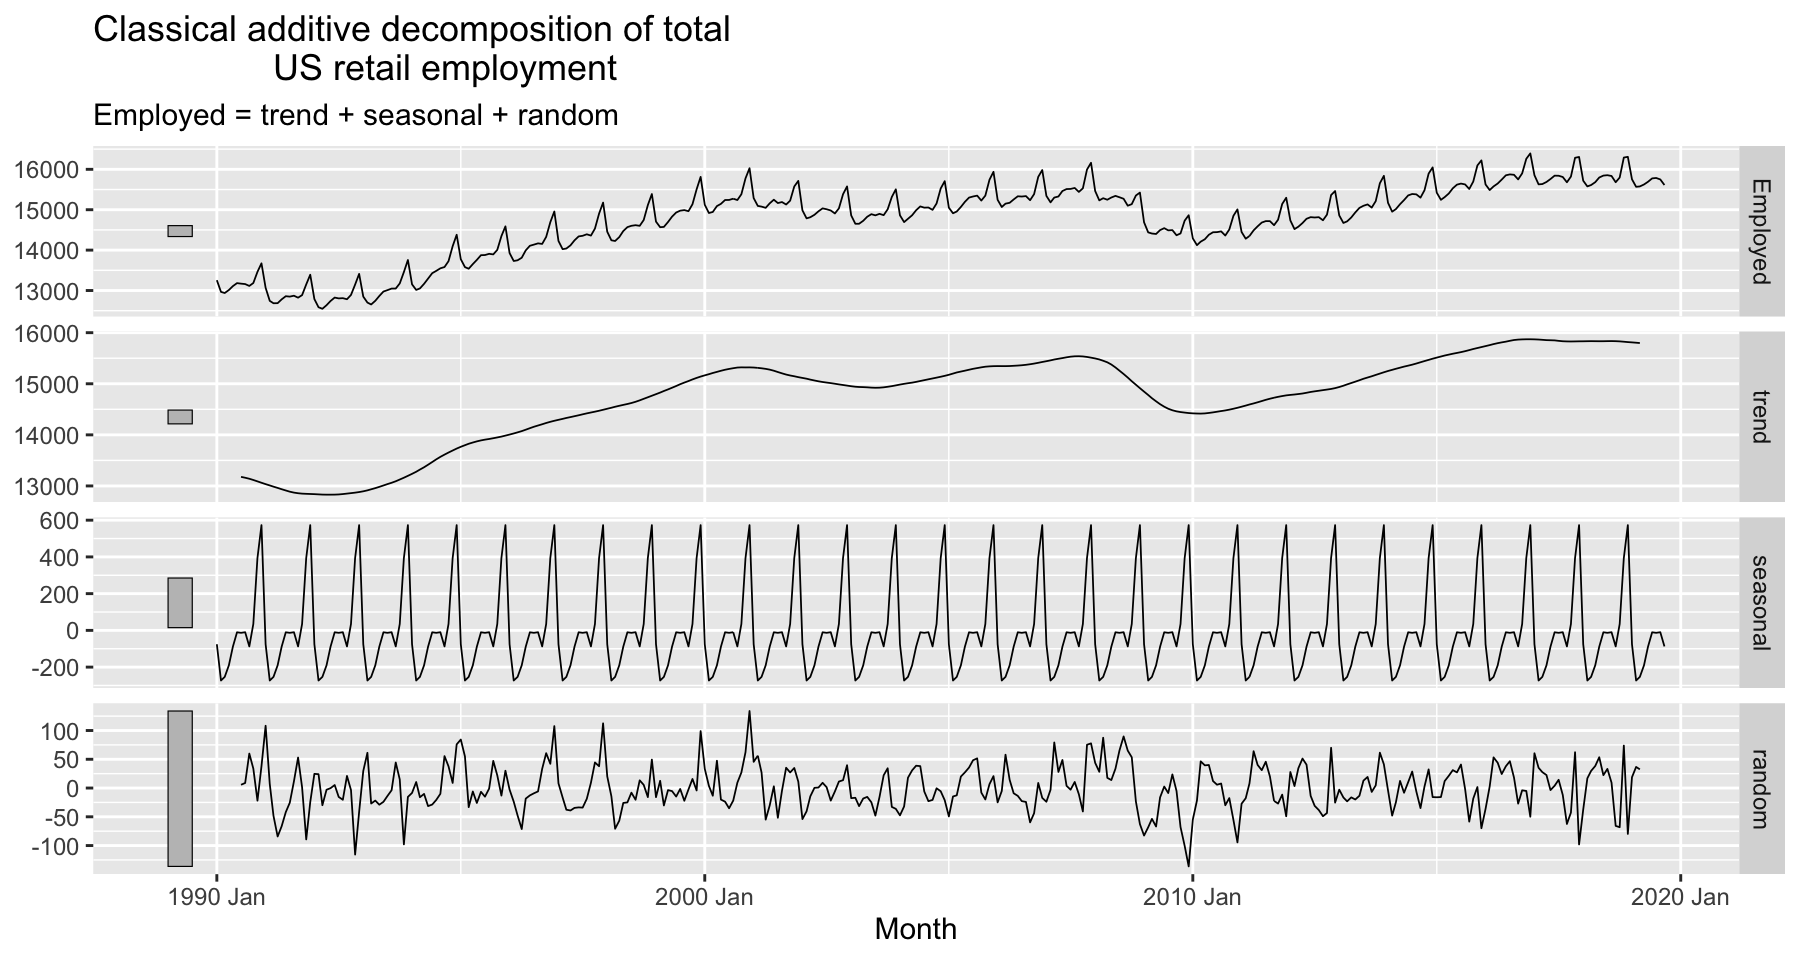

In [86]:
us_retail_employment |>
  model(
    classical_decomposition(Employed, type = "additive")
  ) |>
  components() |>
  autoplot() +
  labs(title = "Classical additive decomposition of total
                  US retail employment")

### Multiplicative decomposition

A classical multiplicative decomposition is similar, except that the subtractions are replaced by divisions.

#### Step 1
If $m$ is an even number, compute the trend-cycle component $\hat{T}_t$ using a $2 \times m$-MA. If $m$ is an odd number, compute the trend-cycle component $\hat{T}_t$ using an $m$-MA.

#### Step 2
Calculate the detrended series: $y_t/\hat{T}_t$.

#### Step 3
To estimate the seasonal component for each season, simply average the detrended values for that season. For example, with monthly data, the seasonal index for March is the average of all the detrended March values in the data. These seasonal indexes are then adjusted to ensure that they add to $m$. The seasonal component is obtained by stringing together these monthly indexes, and then replicating the sequence for each year of data. This gives $\hat{S}_t$.

#### Step 4
The remainder component is calculated by dividing out the estimated seasonal and trend-cycle components: $\hat{R}_t = y_t/(\hat{T}_t\hat{S}_t)$.

### Multiplicative Decomposition Example

Warning message:
“Removed 6 rows containing missing values or values outside the scale range (`geom_line()`).”


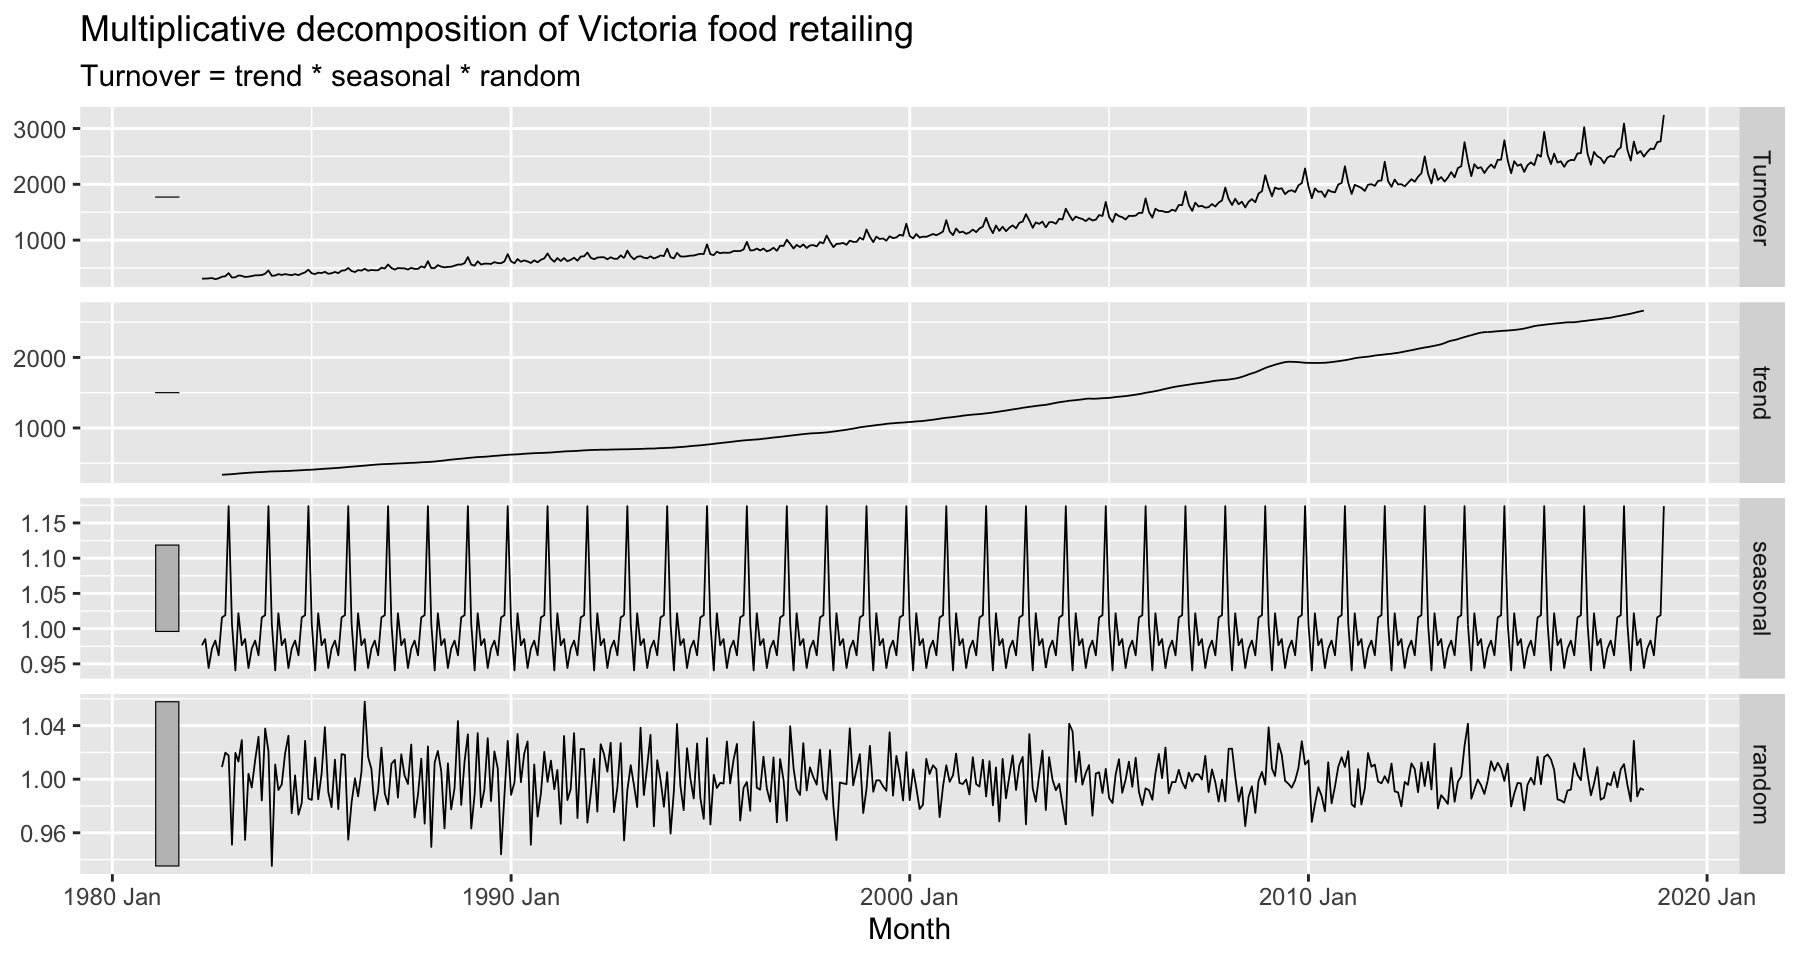

In [90]:
 aus_retail |>
  filter(State == "Victoria", Industry == "Food retailing") |>
  select(Month, Turnover) |>
  model(
    classical_decomposition(Turnover, type = "multiplicative")
  ) |>
  components() |>
  autoplot() +
  labs(title = "Multiplicative decomposition of Victoria food retailing")

## 3.5 Methods used by official statistics agencies

Official statistics agencies (such as the US Census Bureau and the Australian Bureau of Statistics) are responsible for a large number of official economic and social time series. These agencies have developed their own decomposition procedures which are used for seasonal adjustment. Most of them use variants of the `X-11` method, or the `SEATS` method, or a combination of the two. 

### X-11 method

The X-11 method originated in the US Census Bureau and was further developed by Statistics Canada. It is based on classical decomposition, but includes many extra steps and features in order to overcome the drawbacks of classical decomposition that were discussed in the previous section.

With X-11 method, trend-cycle estimates are available for all observations including the end points, and the seasonal component is allowed to vary slowly over time. X-11 also handles trading day variation, holiday effects and the effects of known predictors. 

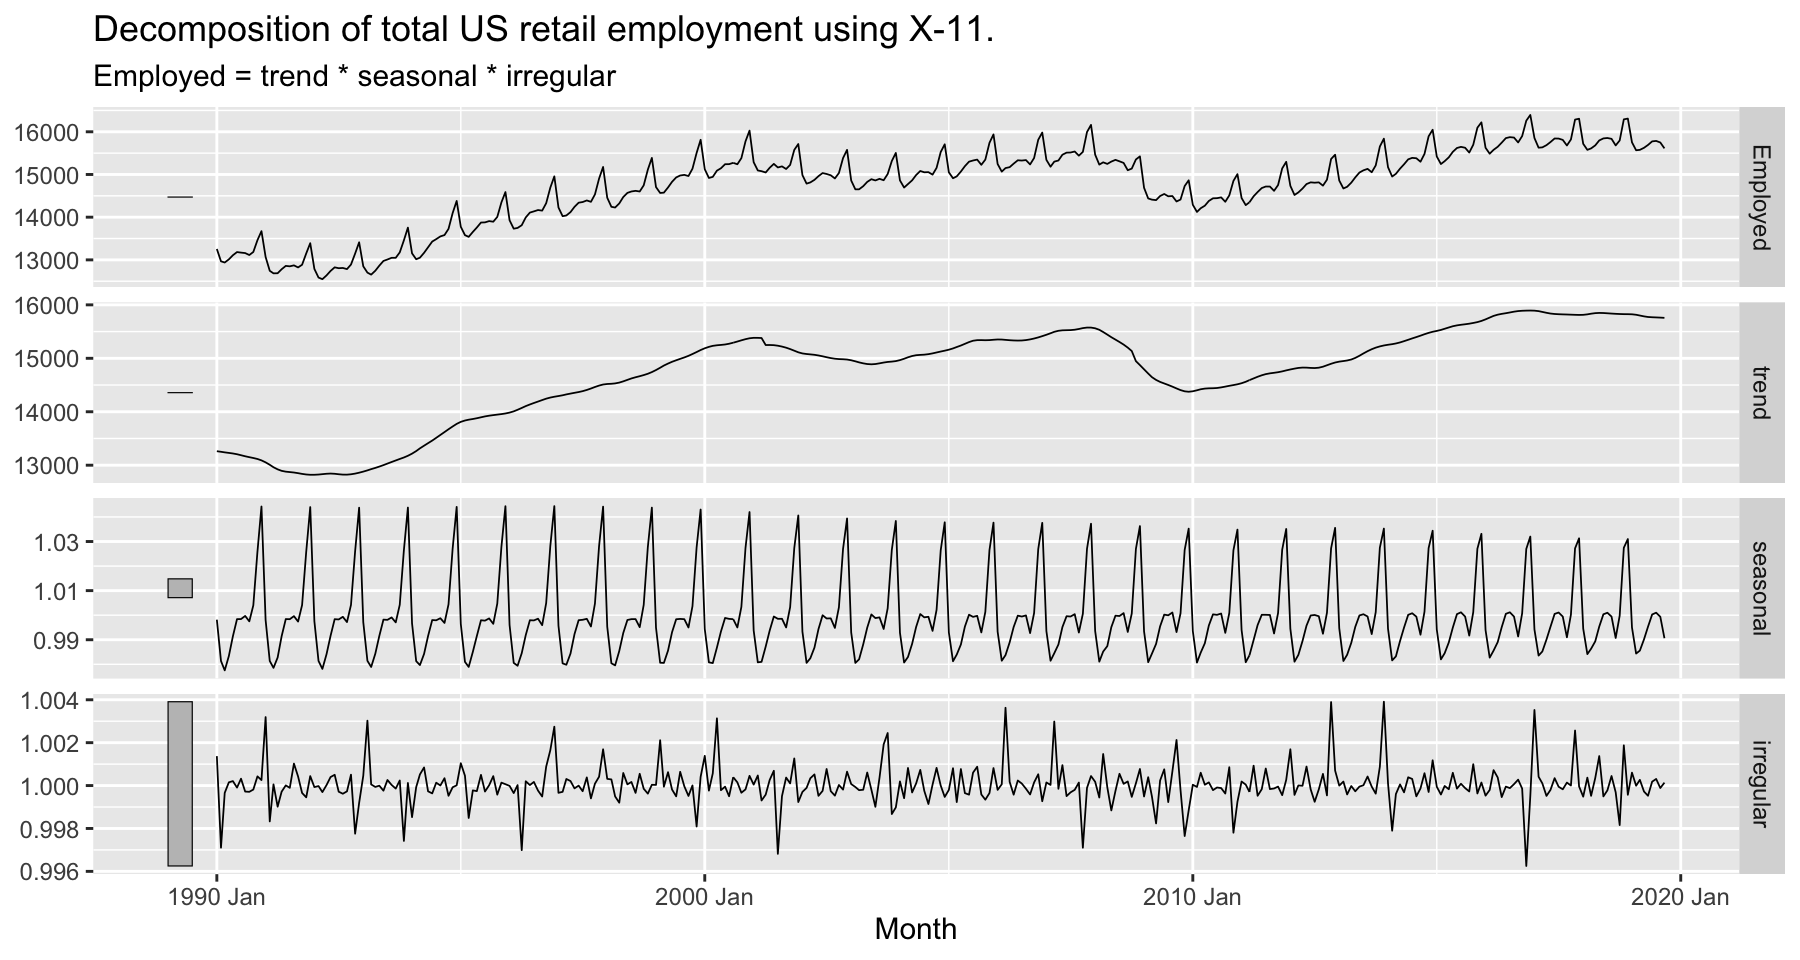

In [91]:
x11_dcmp <- us_retail_employment |>
  model(x11 = X_13ARIMA_SEATS(Employed ~ x11())) |>
  components()
autoplot(x11_dcmp) +
  labs(title =
    "Decomposition of total US retail employment using X-11.")

#### Compare with the classical decomposition

The X-11 trend-cycle has captured the sudden fall in the data due to the 2007–2008 global financial crisis better than either of the other two methods (where the effect of the crisis has leaked into the remainder component).

Warning message:
“Removed 6 rows containing missing values or values outside the scale range (`geom_line()`).”


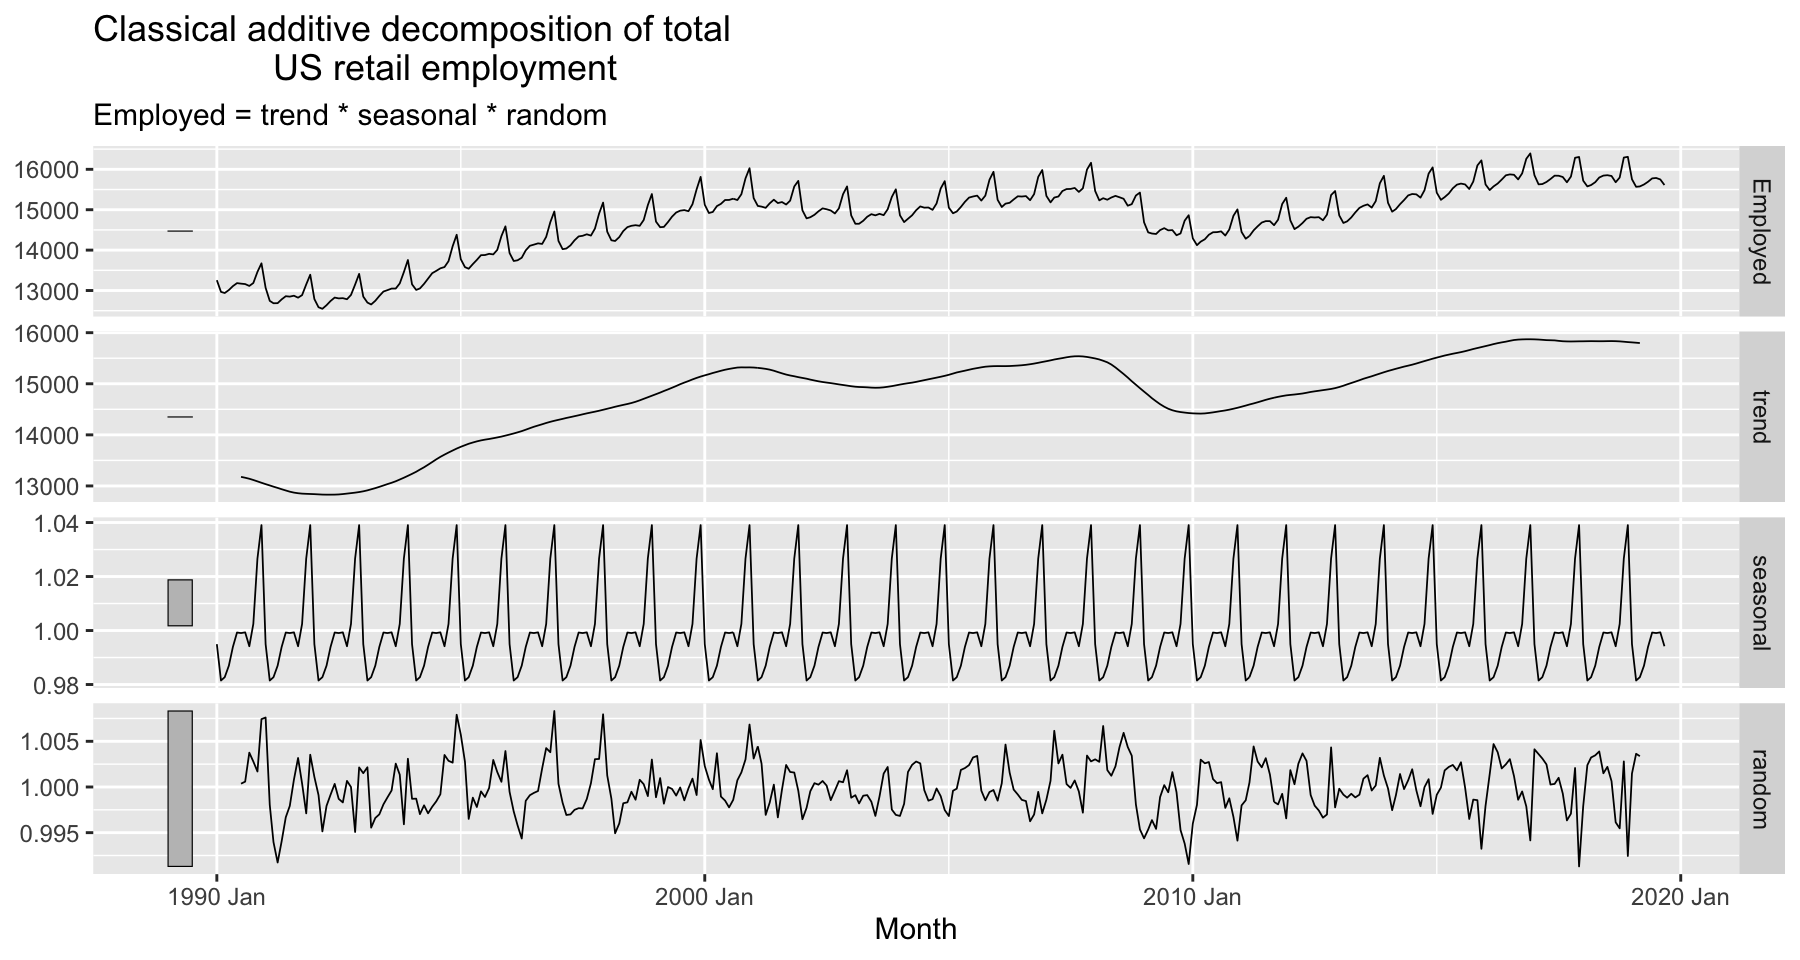

In [94]:
us_retail_employment |>
  model(
    classical_decomposition(Employed, type = "multiplicative") # can change to additive
  ) |>
  components() |>
  autoplot() +
  labs(title = "Classical additive decomposition of total
                  US retail employment")

### Not all Decembers are the same

It can be useful to use seasonal plots and seasonal sub-series plots of the seasonal component, to help us visualise the variation in the seasonal component over time. 

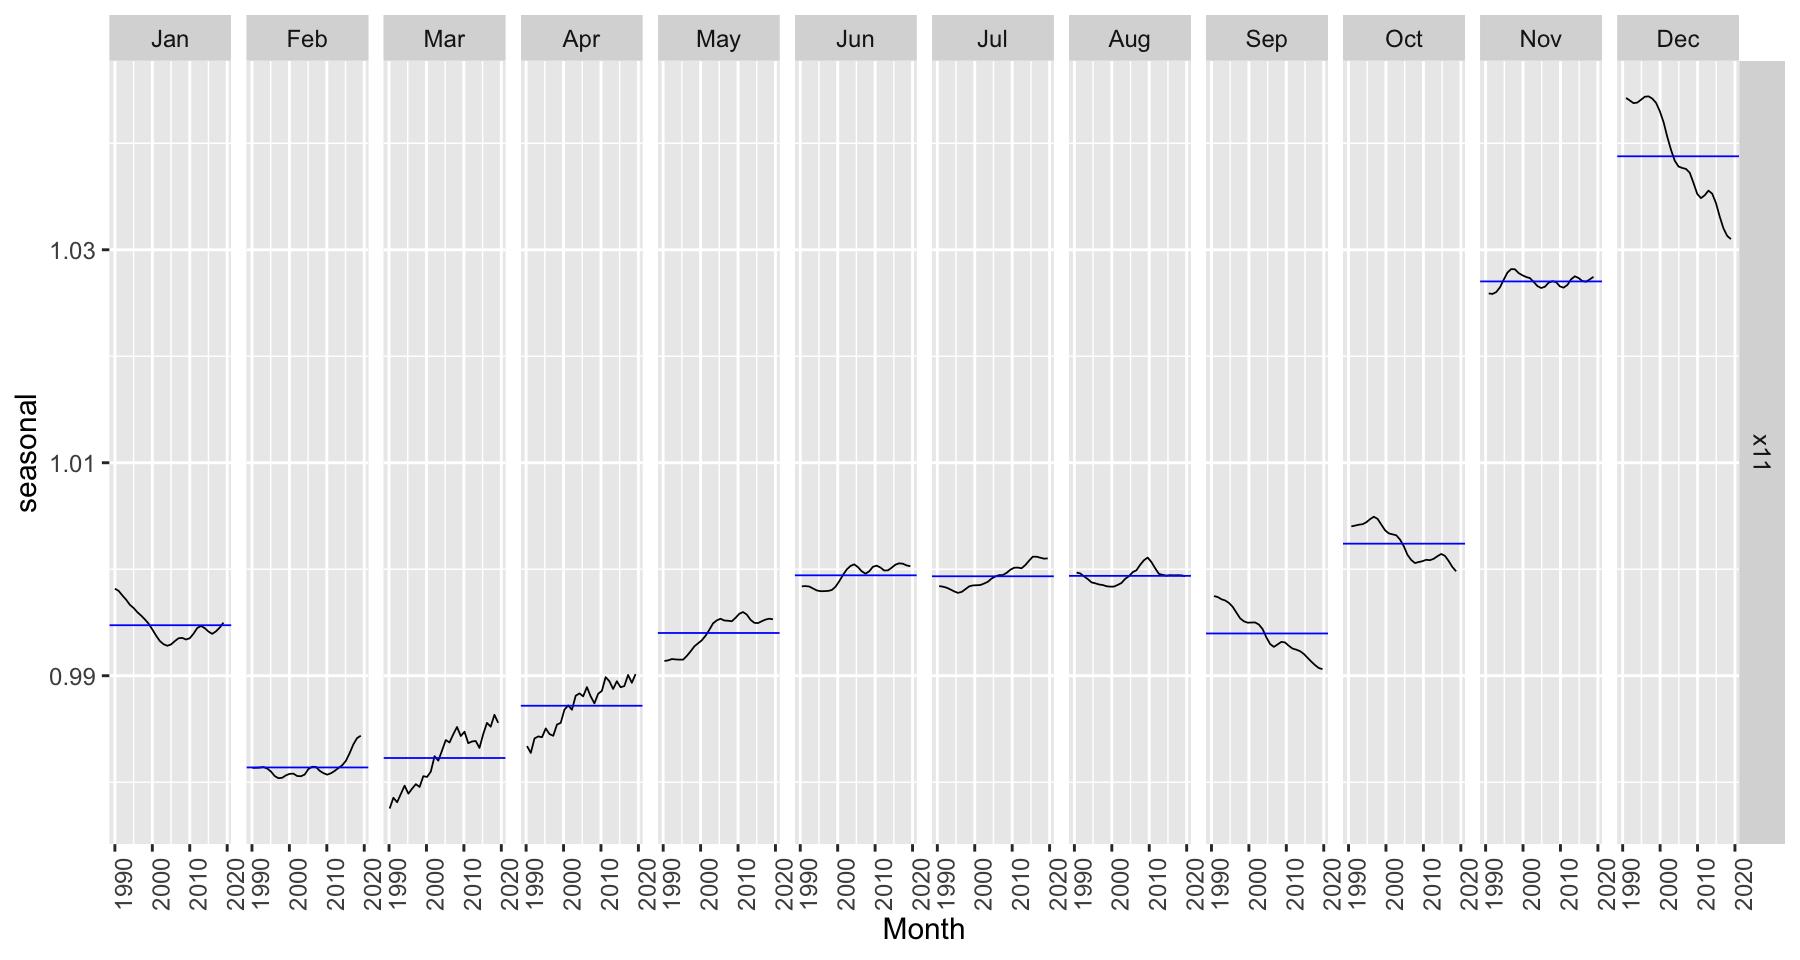

In [95]:
x11_dcmp |>
  gg_subseries(seasonal)

### SEATS method

“SEATS” stands for “Seasonal Extraction in ARIMA Time Series”

This procedure was developed at the Bank of Spain, and is now widely used by government agencies around the world. The details are beyond the scope of this book.

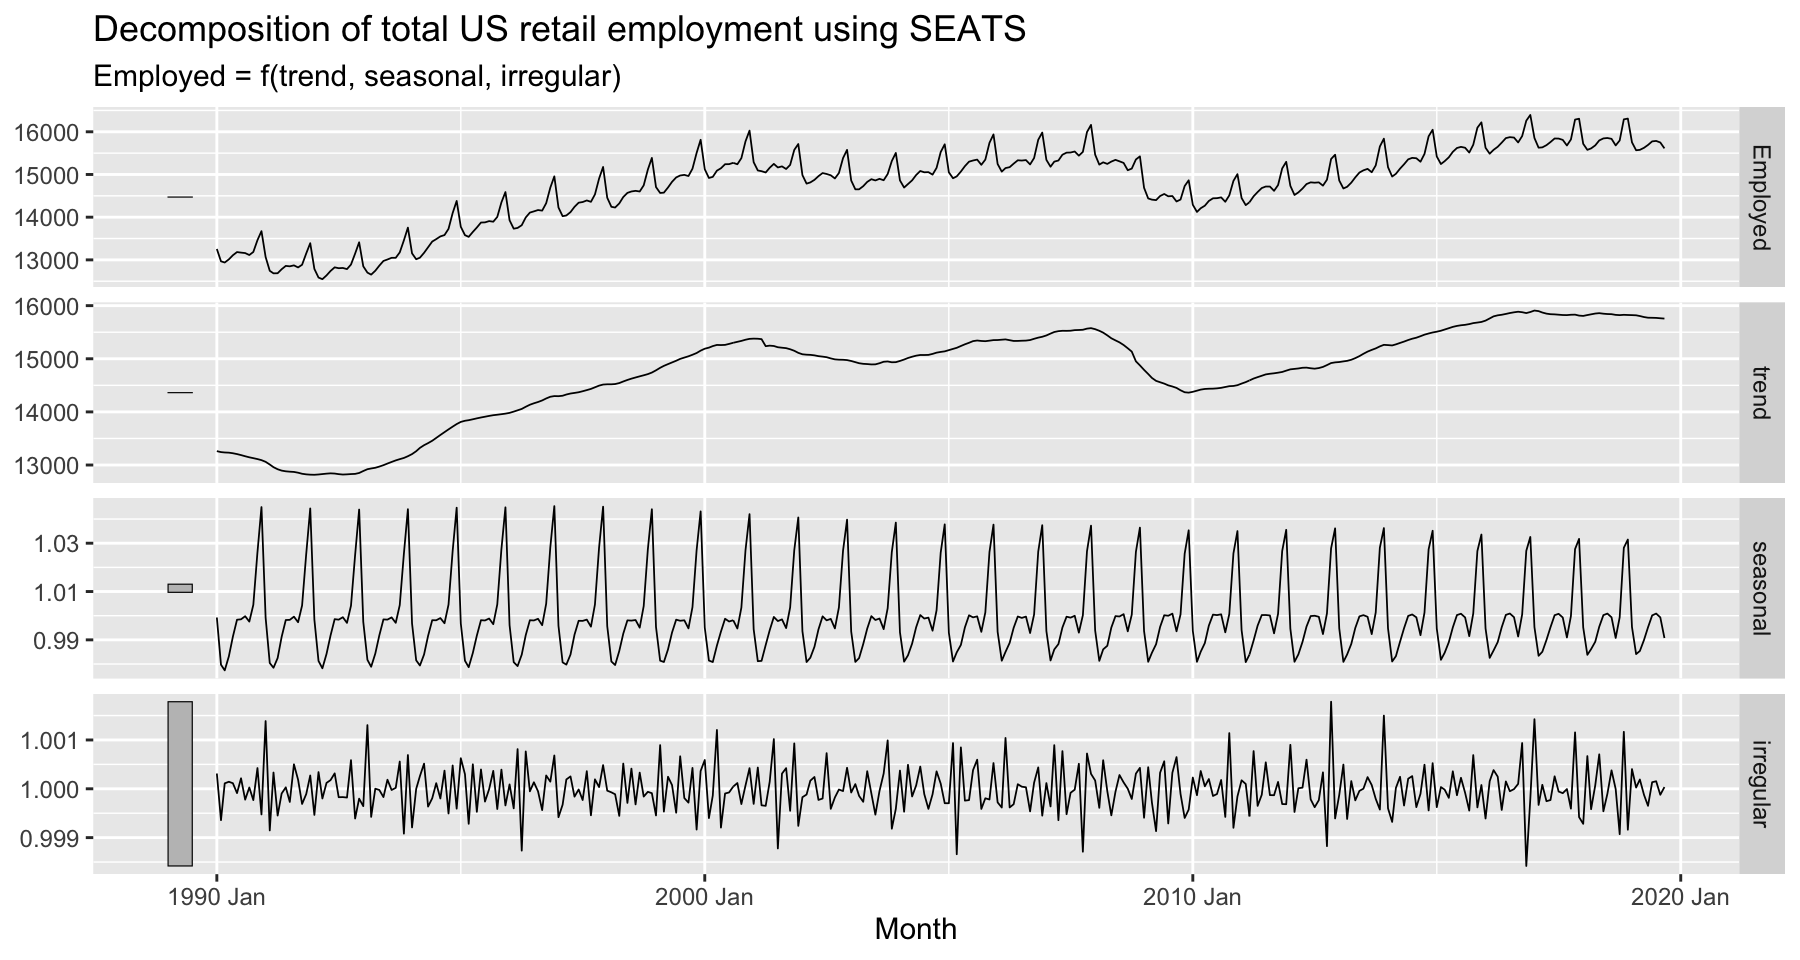

In [96]:
seats_dcmp <- us_retail_employment |>
  model(seats = X_13ARIMA_SEATS(Employed ~ seats())) |>
  components()
autoplot(seats_dcmp) +
  labs(title =
    "Decomposition of total US retail employment using SEATS")

## 3.6 STL decomposition

STL is a versatile and robust method for decomposing time series. STL is an acronym for “**Seasonal and Trend decomposition using Loess**”, while loess is a method for estimating nonlinear relationships.

### Advtanges and Disadvantages of STL

#### Advantages

STL has several advantages over classical decomposition, and the SEATS and X-11 methods:

1. Unlike SEATS and X-11, STL will handle any type of seasonality, not only monthly and quarterly data.
2. The seasonal component is allowed to change over time, and the rate of change can be controlled by the user.
3. The smoothness of the trend-cycle can also be controlled by the user.
4. It can be robust to outliers (i.e., the user can specify a robust decomposition), so that occasional unusual observations will not affect the estimates of the trend-cycle and seasonal components. They will, however, affect the remainder component.

#### Disadvantages

STL has some disadvantages. In particular, it does not handle trading day or calendar variation automatically, and it only provides facilities for additive decompositions.

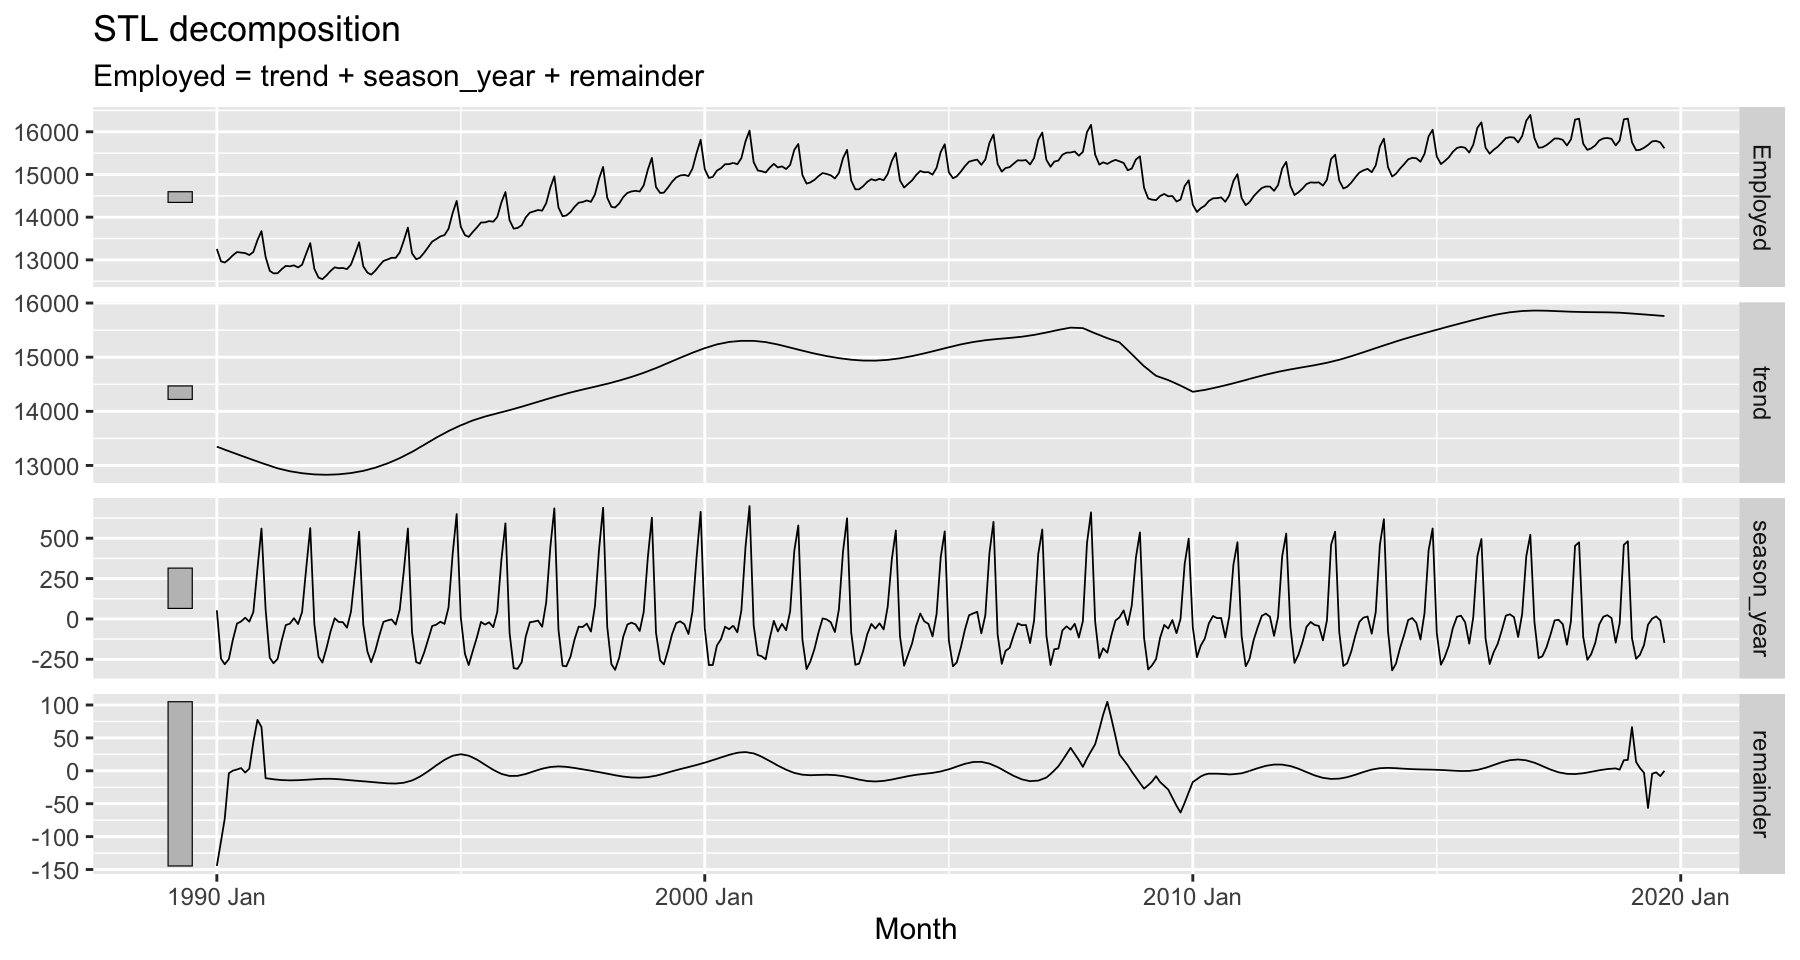

In [101]:
us_retail_employment |>
  model(
    STL(Employed ~ trend(window = 21) + # play with this numbers and see what will happen
                   season(window = "periodic"), # play with this numbers and see what will happen
    robust = TRUE)) |>
  components() |>
  autoplot()

The two parameters control how rapidly the trend-cycle and seasonal components can change. Smaller values allow for more rapid changes. Both trend and seasonal windows should be odd numbers; trend window is the number of consecutive observations to be used when estimating the trend-cycle; season window is the **number of consecutive years to be used in estimating each value in the seasonal component**. Setting the seasonal window to be infinite is equivalent to forcing the seasonal component to be periodic `season(window='periodic')` (i.e., identical across years).

### The effect of trend window and seasonality window

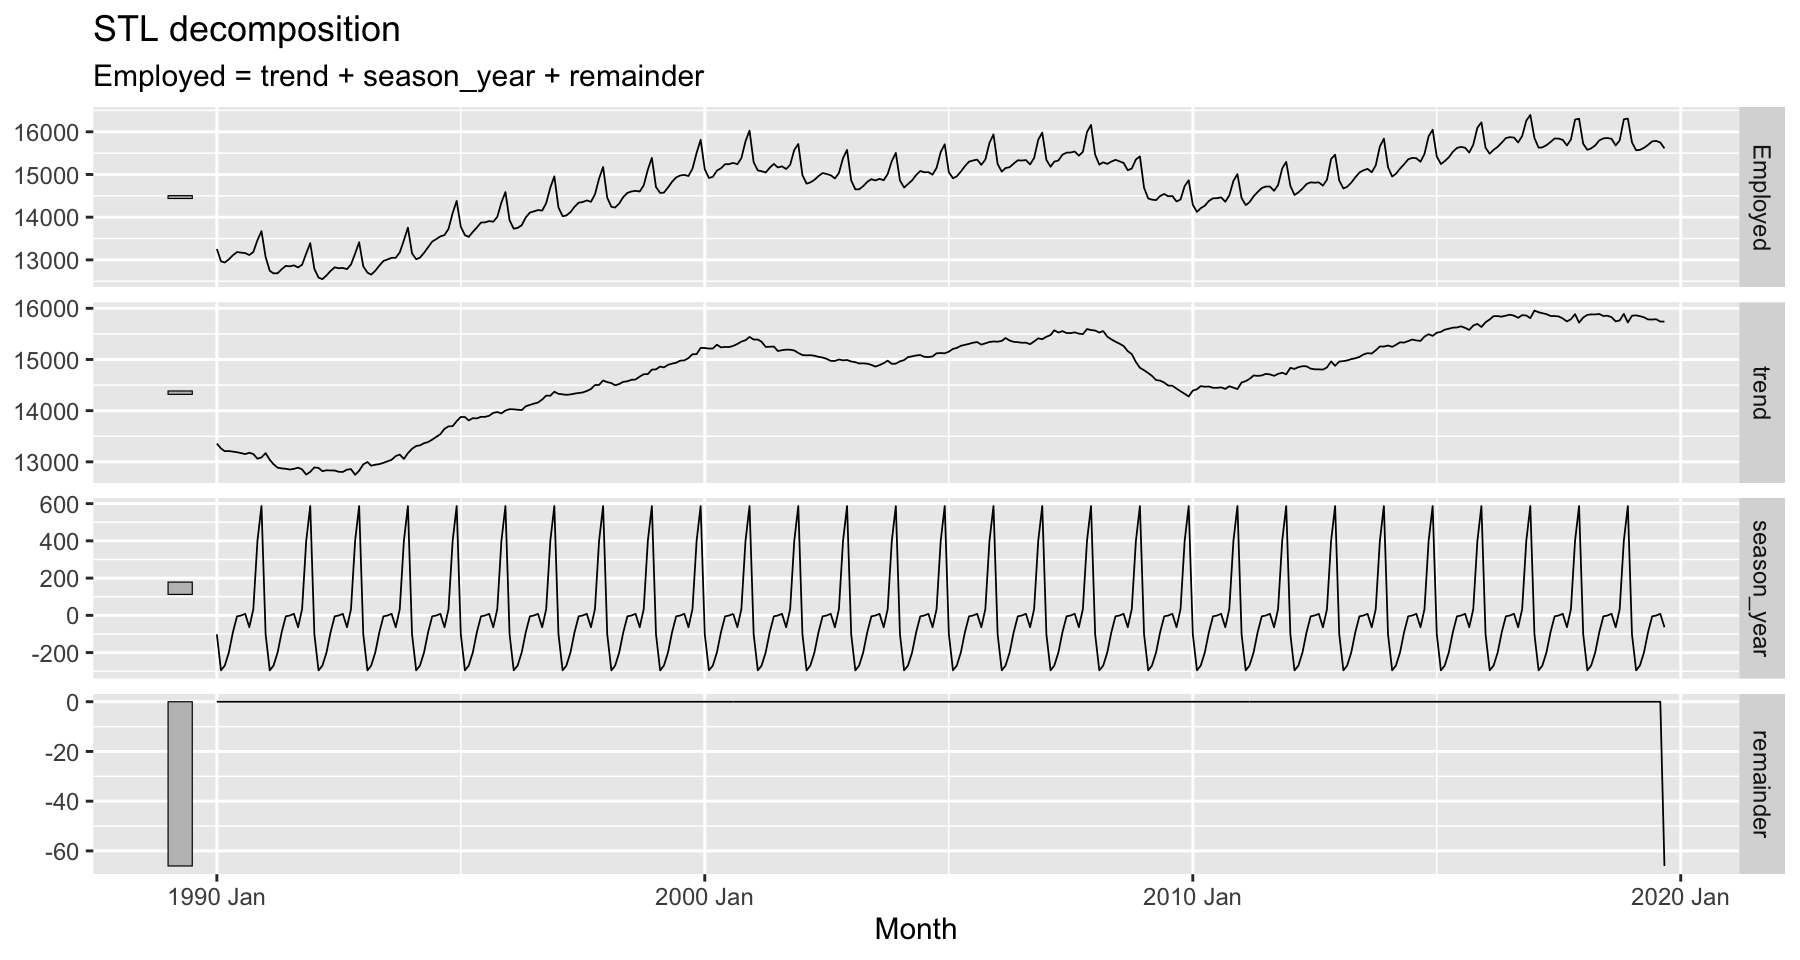

In [105]:
us_retail_employment |>
  model(
    STL(Employed ~ trend(window = 3) + # Quiz: Why isn't trend component less smooth? Why the remainders are almost 0 all the time
                   season(window = "periodic"),
    robust = TRUE)) |>
  components() |>
  autoplot()

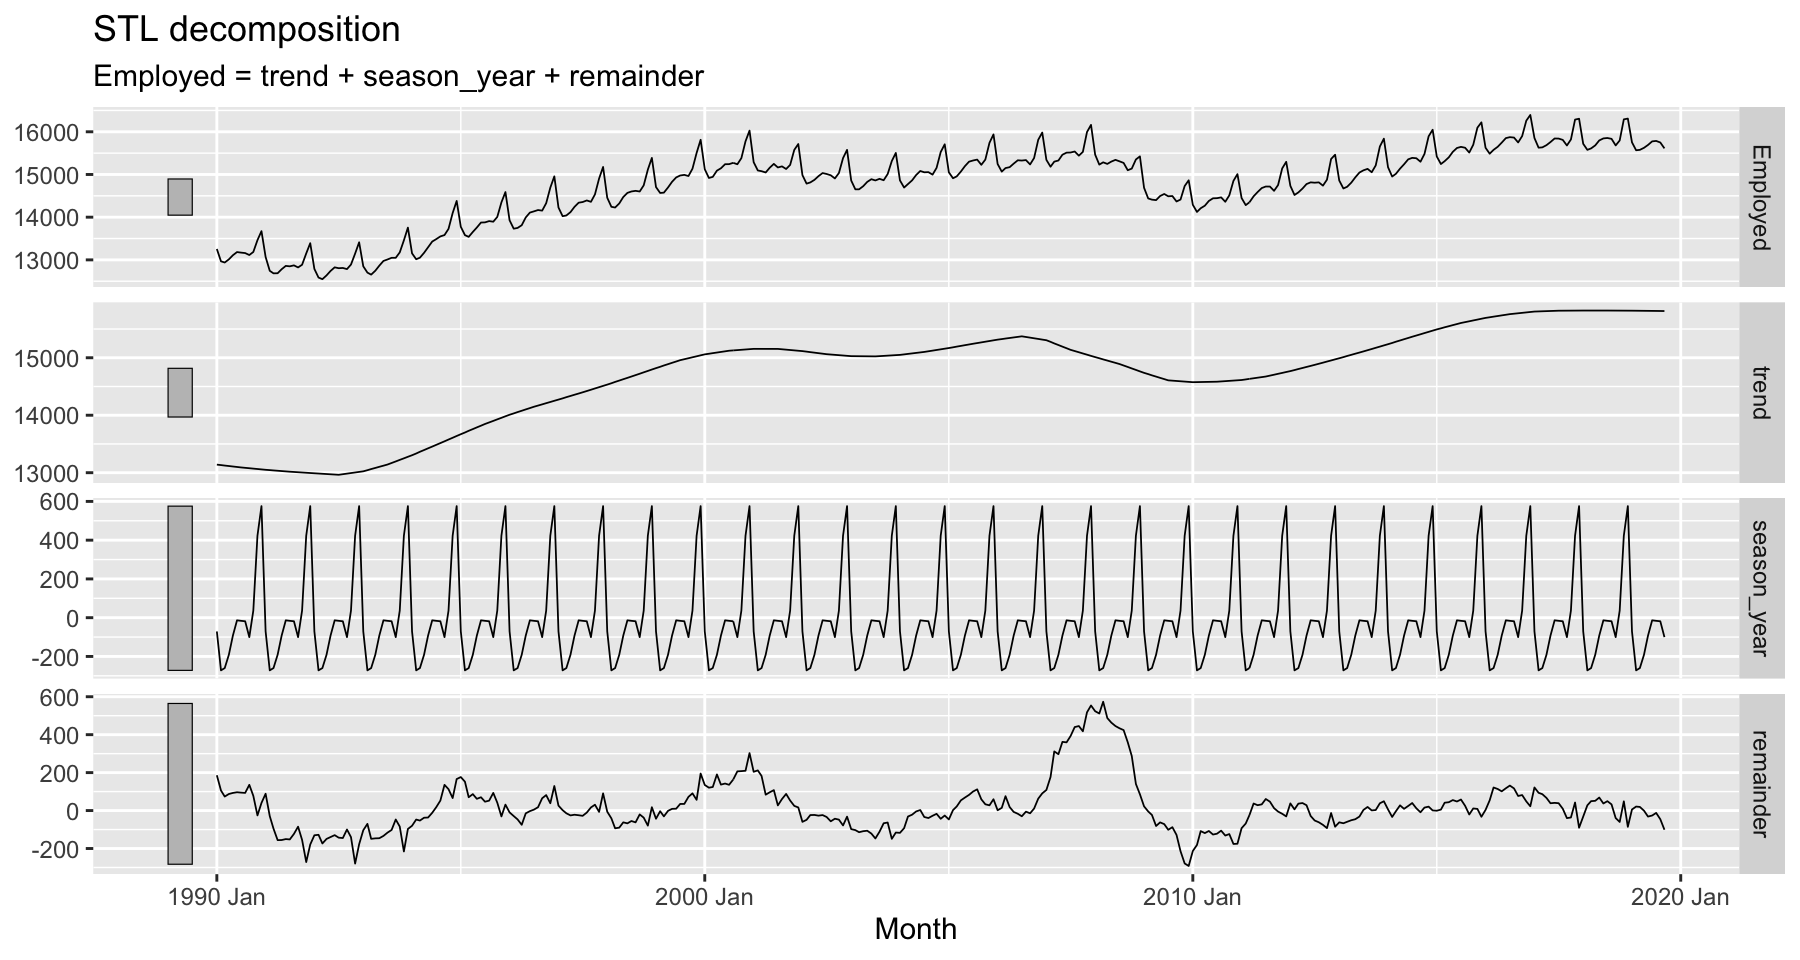

In [108]:
us_retail_employment |>
  model(
    STL(Employed ~ trend(window = 60) + # Quiz: Can you conclude that the 2008 financial crisis is just a random "accident"? 
                    # Hint: also look at the grey bar on the left
                   season(window = "periodic"),
    robust = TRUE)) |>
  components() |>
  autoplot()

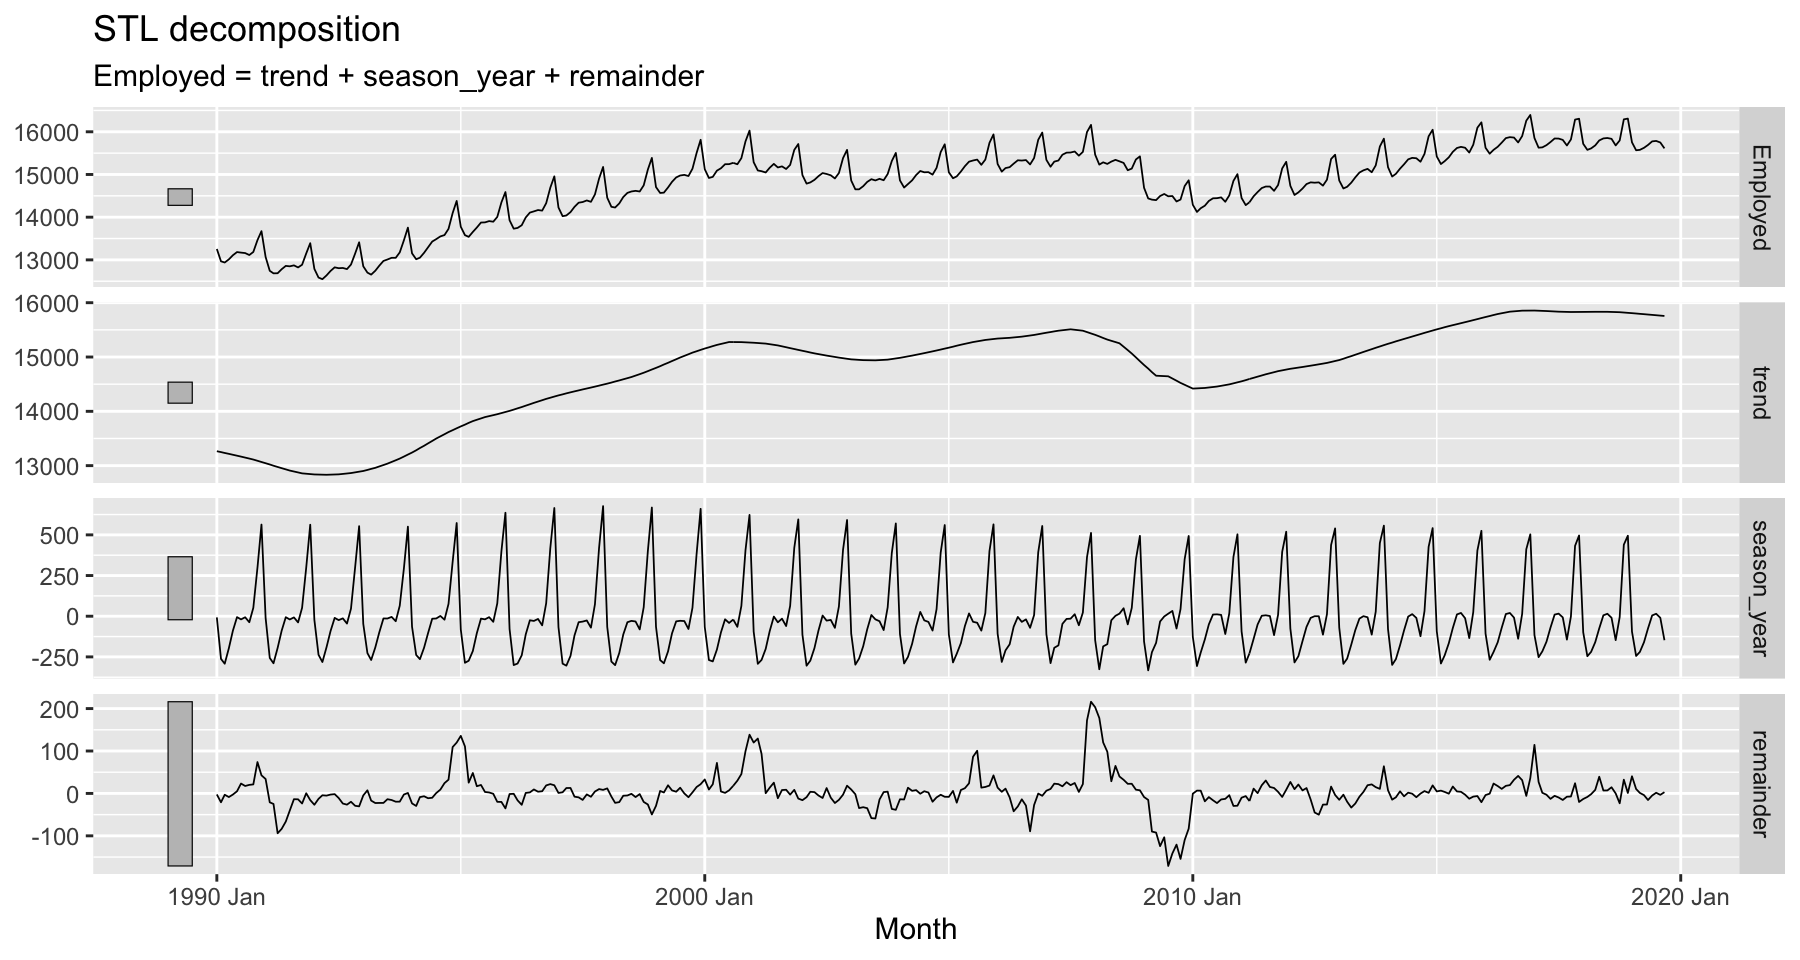

In [112]:
us_retail_employment |>
  model(
    STL(Employed ~ trend(window = 21) + 
                   season(window = 5), # Quiz: How will this parameter affect the variation of the seasonal component?
    robust = TRUE)) |>
  components() |>
  autoplot()